## Step 1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, iou_pytorch_test, IoULoss, IoUBCELoss

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet_attention import UNet_attention

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [9]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180), # allow any rotation
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to augment or not

In [10]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"


# pre-defined split
with open('../train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=train_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [11]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

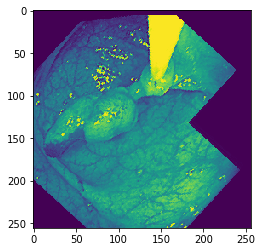

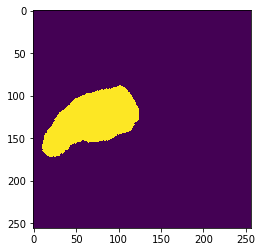

In [12]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [13]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [14]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

## Pipeline

In [15]:
def train(model, optim, criterion, dataloader, epoch, device):
    pass

In [16]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    pass

# Training hyperparameters

In [17]:
# Begin training
model = UNet_attention(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [18]:
# Define variables for the training
epochs = 70

In [20]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_attention'

criterion = IoULoss()
model_name = 'UNet_IoULoss_attention'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_attention'


# Training

 Epoch: 0 of 70, Iter.: 44 of 44, Loss: -0.205847, Val. Loss: -0.202759
 Epoch: 0 of 70, Iter.: 44 of 44, IoU: 0.265490, Val. IoU: 0.237259


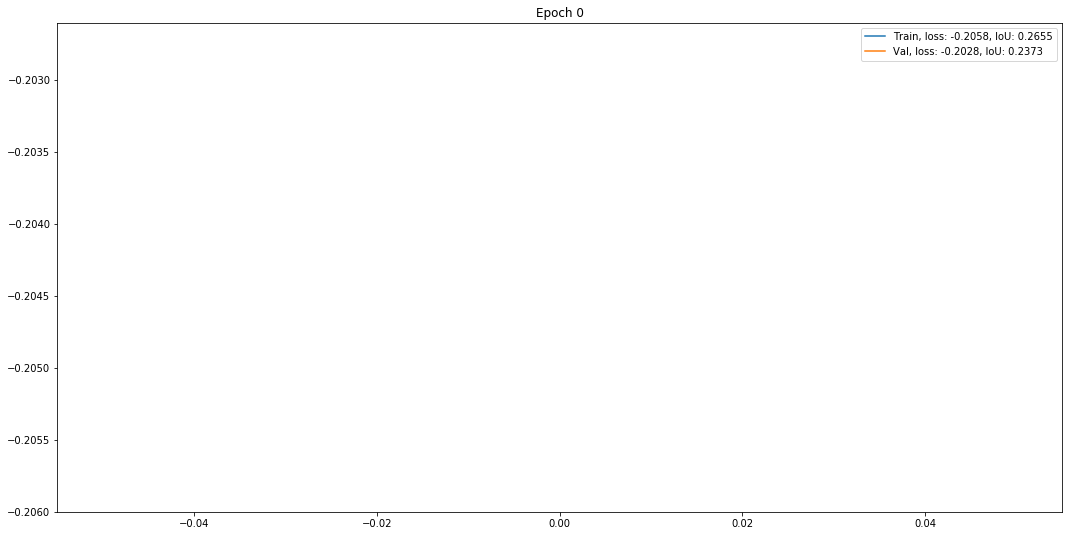

 Epoch: 1 of 70, Iter.: 44 of 44, Loss: -0.236085, Val. Loss: -0.214054
 Epoch: 1 of 70, Iter.: 44 of 44, IoU: 0.289887, Val. IoU: 0.245125


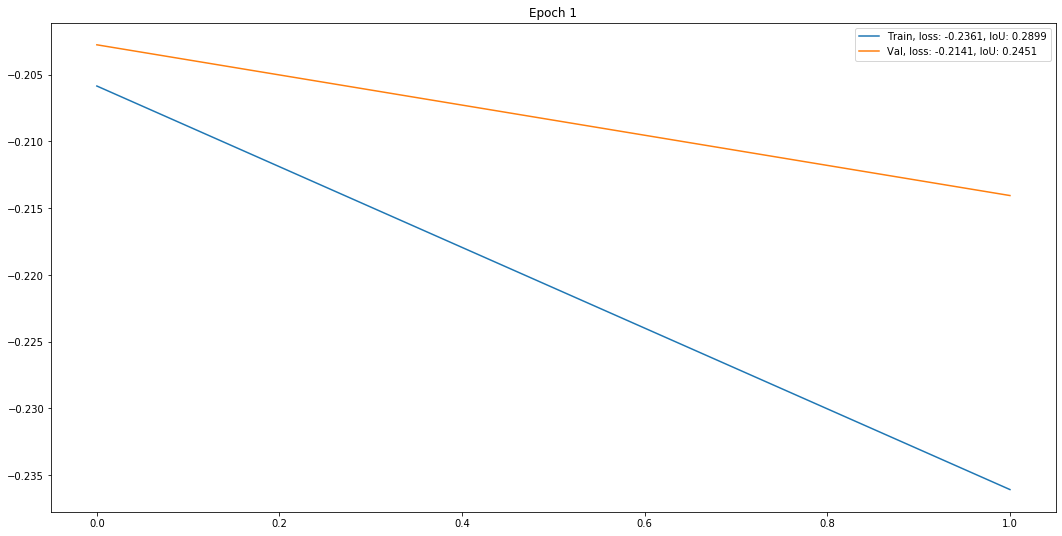

 Epoch: 2 of 70, Iter.: 44 of 44, Loss: -0.244088, Val. Loss: -0.218358
 Epoch: 2 of 70, Iter.: 44 of 44, IoU: 0.294452, Val. IoU: 0.249159


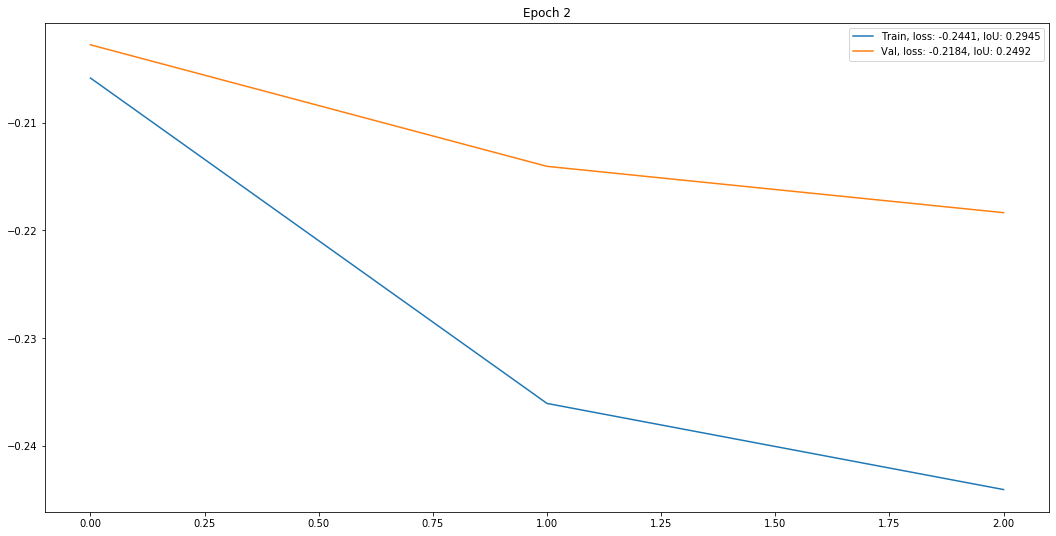

 Epoch: 3 of 70, Iter.: 44 of 44, Loss: -0.251111, Val. Loss: -0.221494
 Epoch: 3 of 70, Iter.: 44 of 44, IoU: 0.297955, Val. IoU: 0.252820


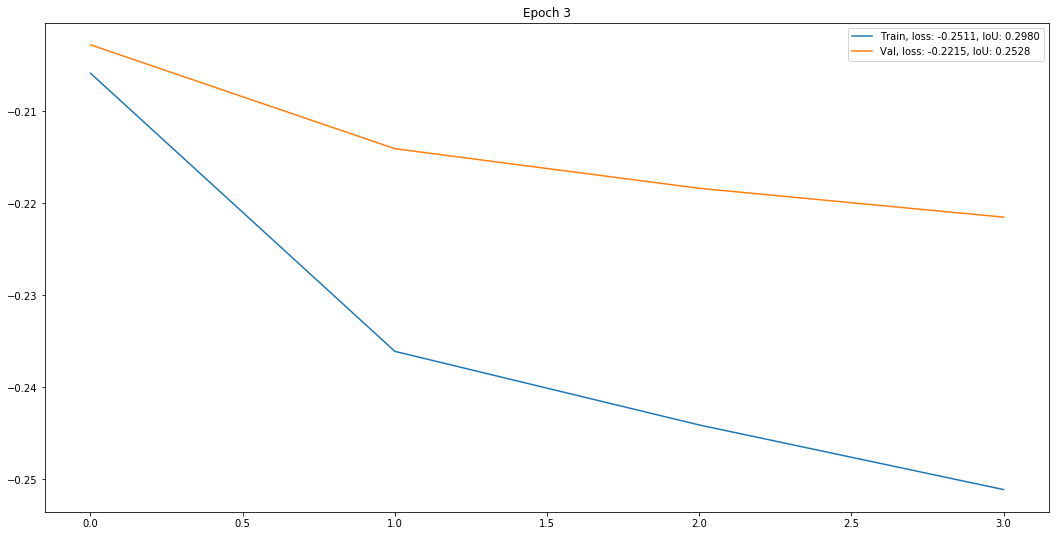

 Epoch: 4 of 70, Iter.: 44 of 44, Loss: -0.257969, Val. Loss: -0.224647
 Epoch: 4 of 70, Iter.: 44 of 44, IoU: 0.301555, Val. IoU: 0.256065


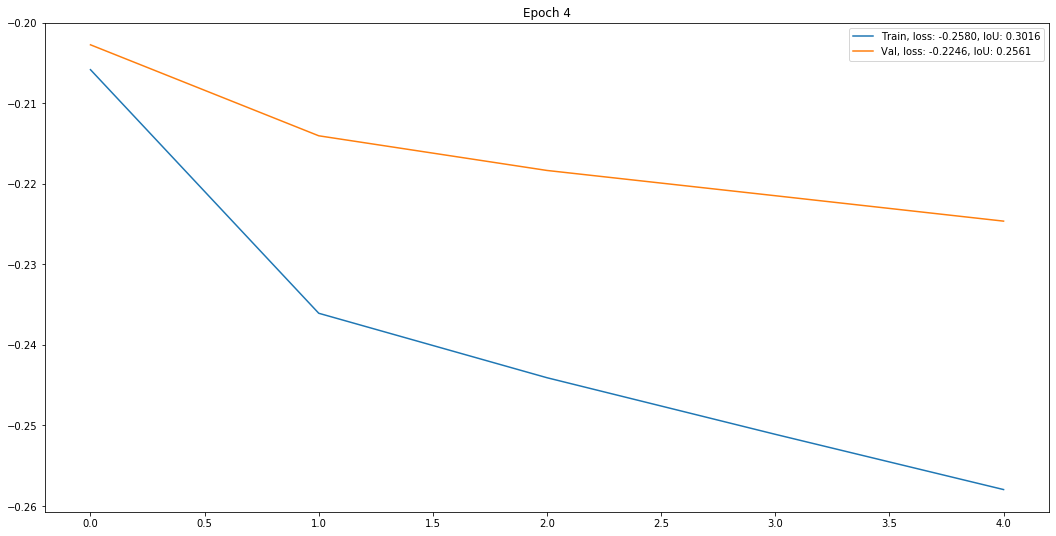

 Epoch: 5 of 70, Iter.: 44 of 44, Loss: -0.264052, Val. Loss: -0.228950
 Epoch: 5 of 70, Iter.: 44 of 44, IoU: 0.304848, Val. IoU: 0.257838


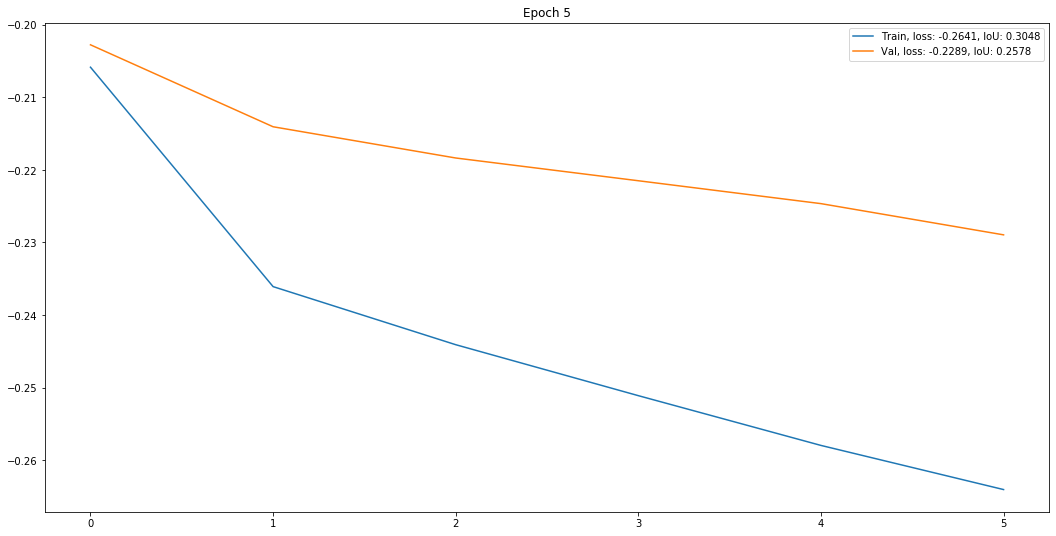

 Epoch: 6 of 70, Iter.: 44 of 44, Loss: -0.268500, Val. Loss: -0.232924
 Epoch: 6 of 70, Iter.: 44 of 44, IoU: 0.306958, Val. IoU: 0.259462


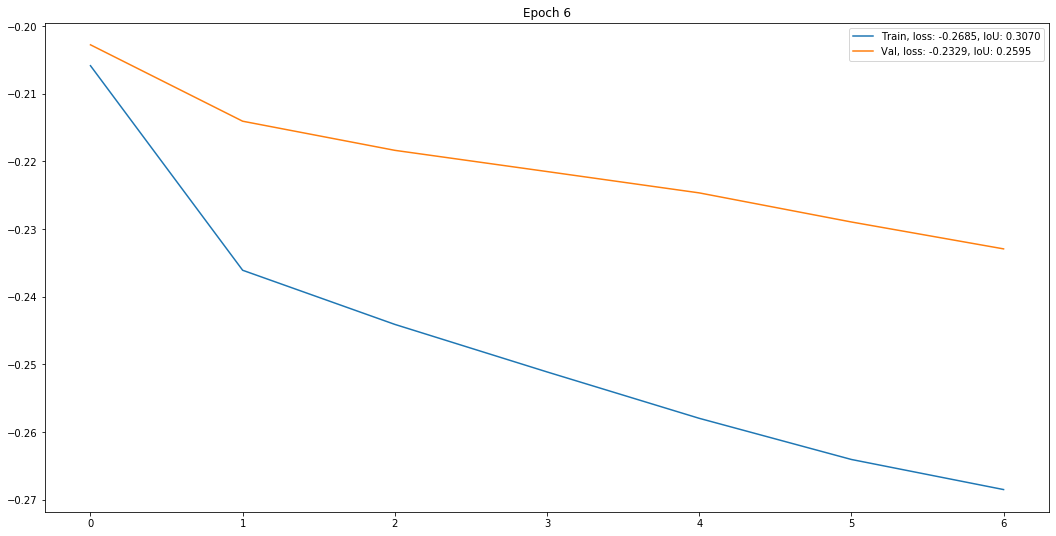

 Epoch: 7 of 70, Iter.: 44 of 44, Loss: -0.273627, Val. Loss: -0.236030
 Epoch: 7 of 70, Iter.: 44 of 44, IoU: 0.309046, Val. IoU: 0.262280


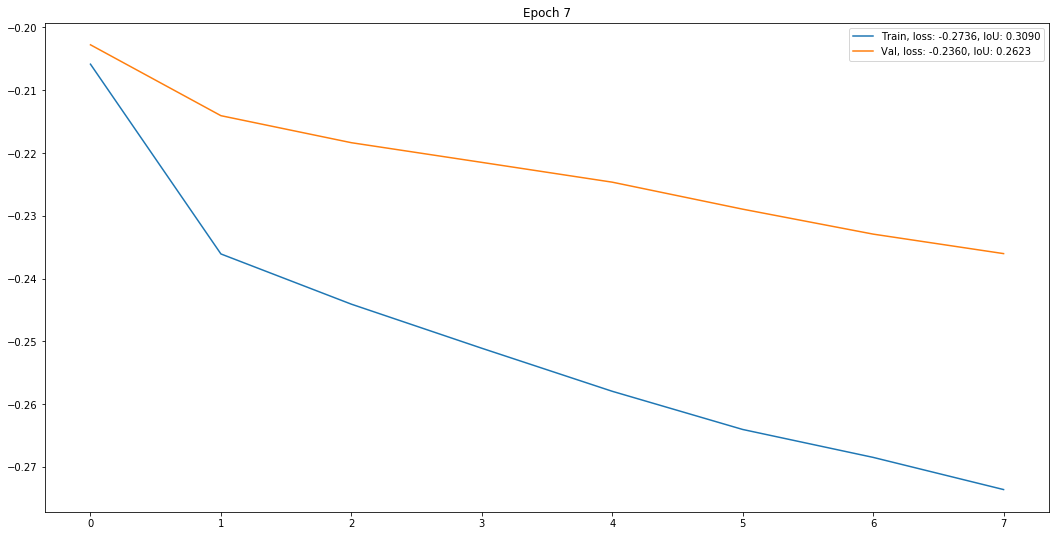

 Epoch: 8 of 70, Iter.: 44 of 44, Loss: -0.277320, Val. Loss: -0.237518
 Epoch: 8 of 70, Iter.: 44 of 44, IoU: 0.310031, Val. IoU: 0.261994


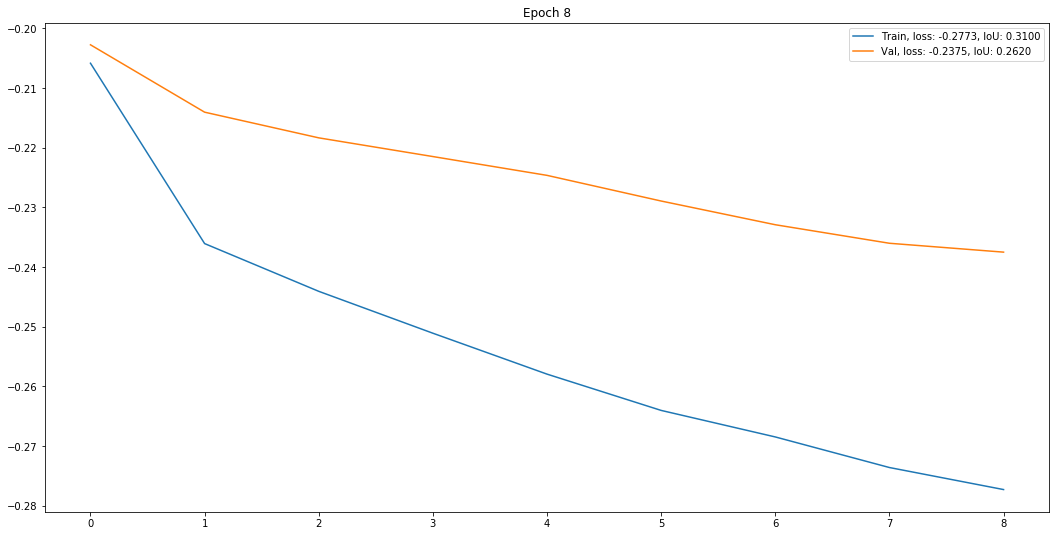

 Epoch: 9 of 70, Iter.: 44 of 44, Loss: -0.281575, Val. Loss: -0.240724
 Epoch: 9 of 70, Iter.: 44 of 44, IoU: 0.311973, Val. IoU: 0.262121


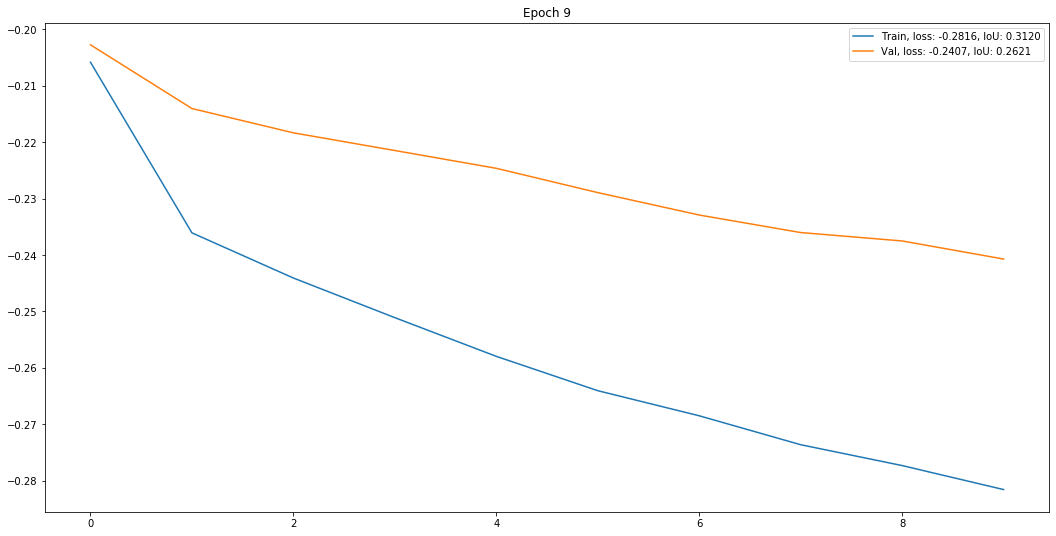

 Epoch: 10 of 70, Iter.: 44 of 44, Loss: -0.284382, Val. Loss: -0.242607
 Epoch: 10 of 70, Iter.: 44 of 44, IoU: 0.313031, Val. IoU: 0.262025


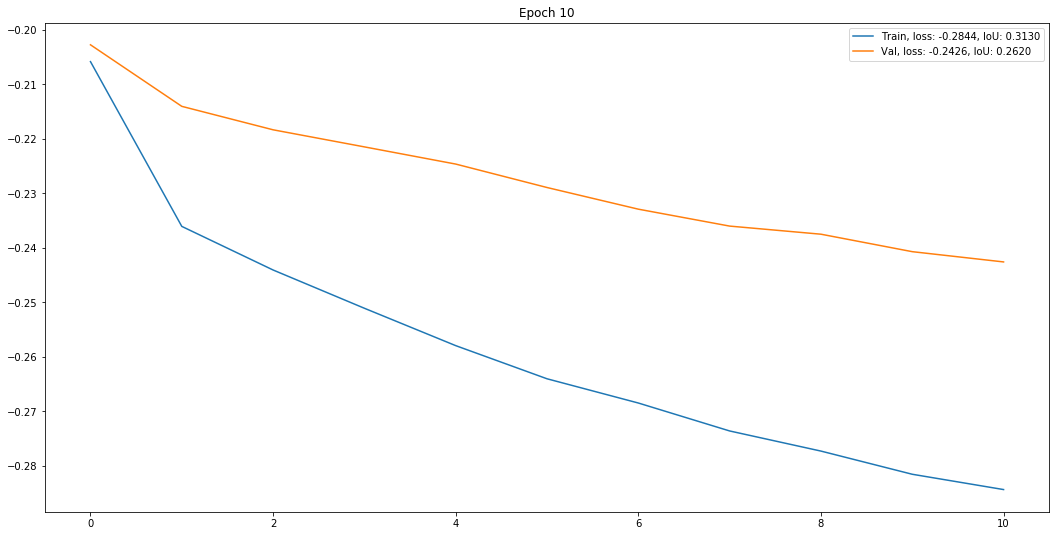

 Epoch: 11 of 70, Iter.: 44 of 44, Loss: -0.287337, Val. Loss: -0.244949
 Epoch: 11 of 70, Iter.: 44 of 44, IoU: 0.314340, Val. IoU: 0.262011


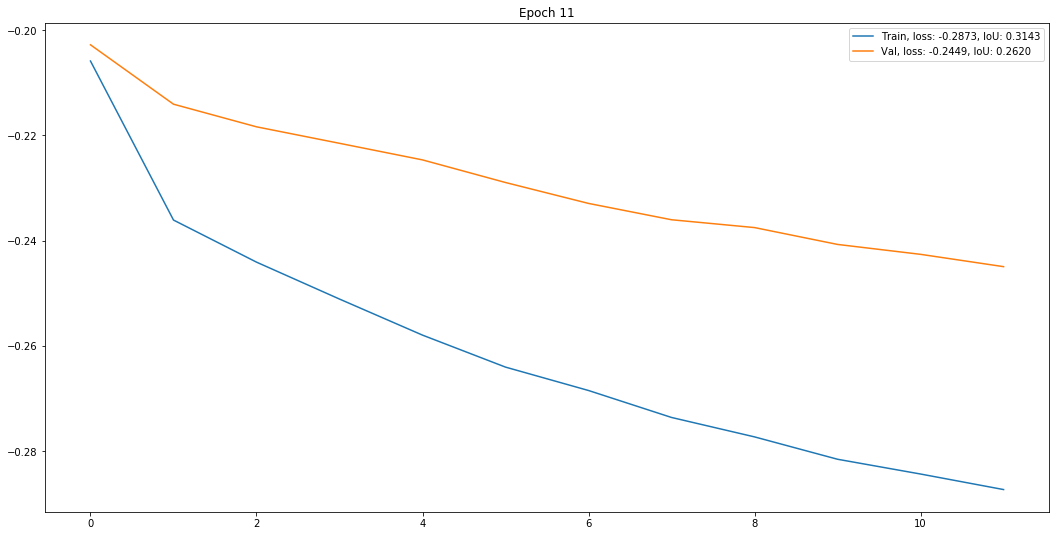

 Epoch: 12 of 70, Iter.: 44 of 44, Loss: -0.289467, Val. Loss: -0.248447
 Epoch: 12 of 70, Iter.: 44 of 44, IoU: 0.314578, Val. IoU: 0.264421


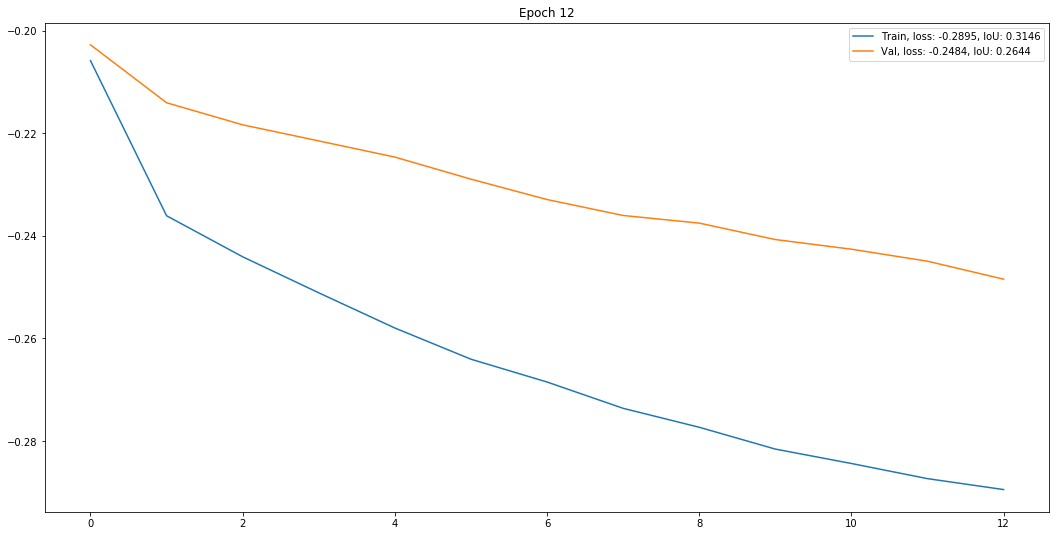

 Epoch: 13 of 70, Iter.: 44 of 44, Loss: -0.292079, Val. Loss: -0.249156
 Epoch: 13 of 70, Iter.: 44 of 44, IoU: 0.315319, Val. IoU: 0.263087


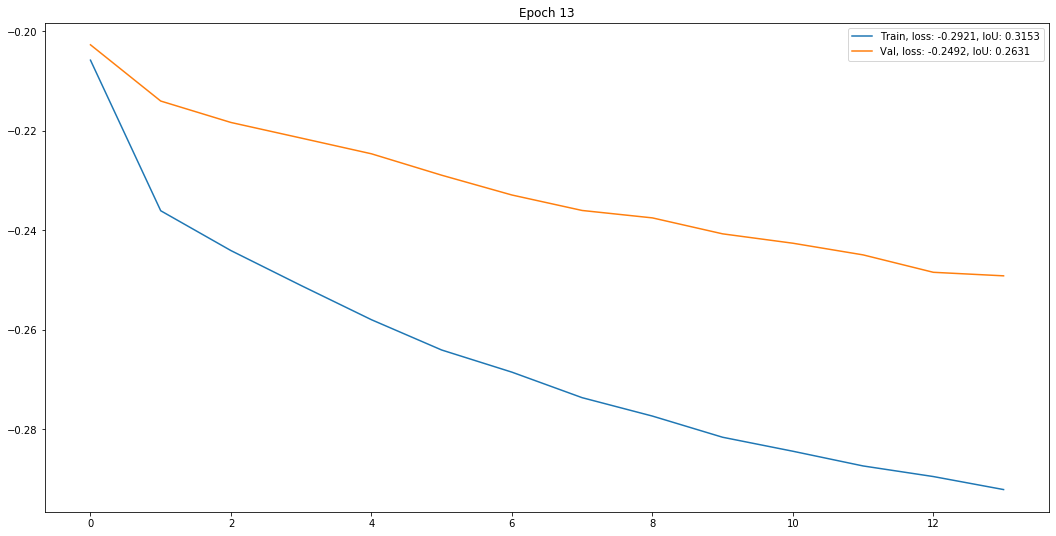

 Epoch: 14 of 70, Iter.: 44 of 44, Loss: -0.294506, Val. Loss: -0.251565
 Epoch: 14 of 70, Iter.: 44 of 44, IoU: 0.316275, Val. IoU: 0.263142


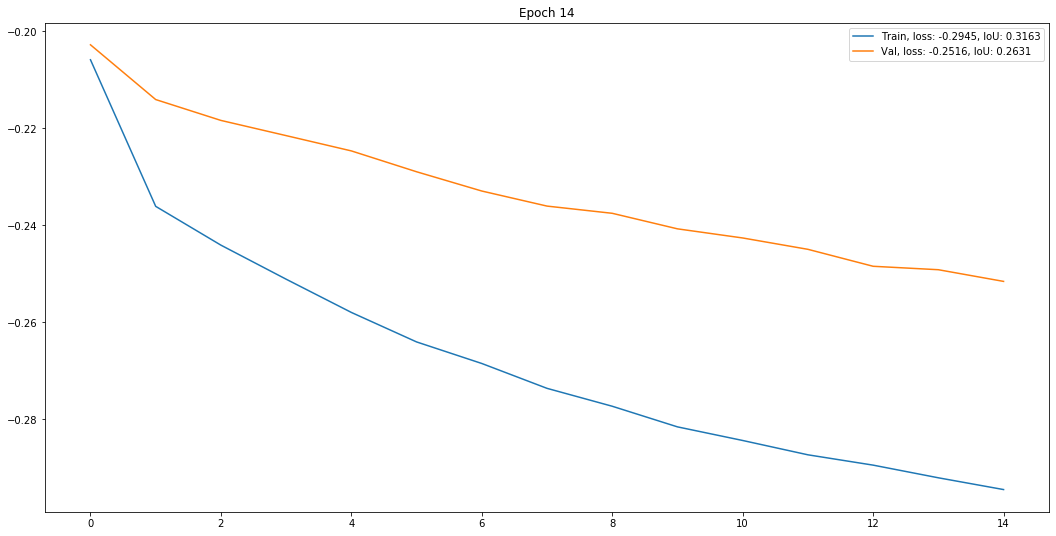

 Epoch: 15 of 70, Iter.: 44 of 44, Loss: -0.296615, Val. Loss: -0.251746
 Epoch: 15 of 70, Iter.: 44 of 44, IoU: 0.317025, Val. IoU: 0.261368


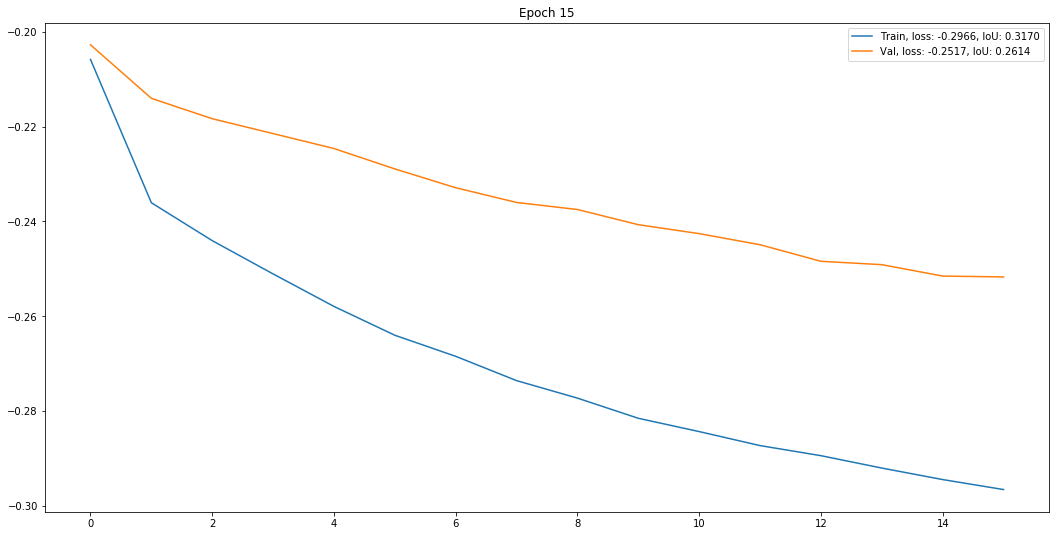

 Epoch: 16 of 70, Iter.: 44 of 44, Loss: -0.298779, Val. Loss: -0.250256
 Epoch: 16 of 70, Iter.: 44 of 44, IoU: 0.318256, Val. IoU: 0.255081


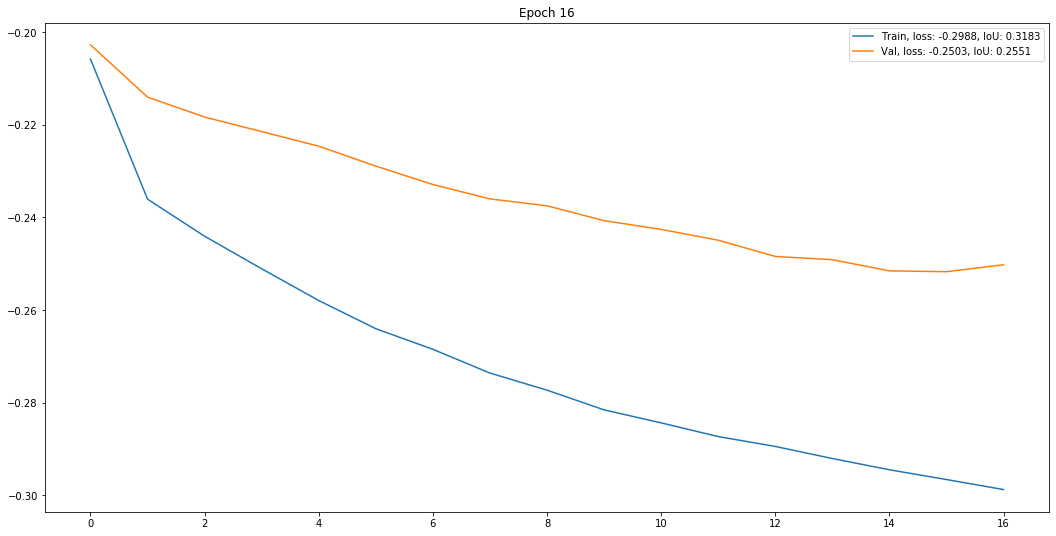

 Epoch: 17 of 70, Iter.: 44 of 44, Loss: -0.299202, Val. Loss: -0.253006
 Epoch: 17 of 70, Iter.: 44 of 44, IoU: 0.317425, Val. IoU: 0.253420


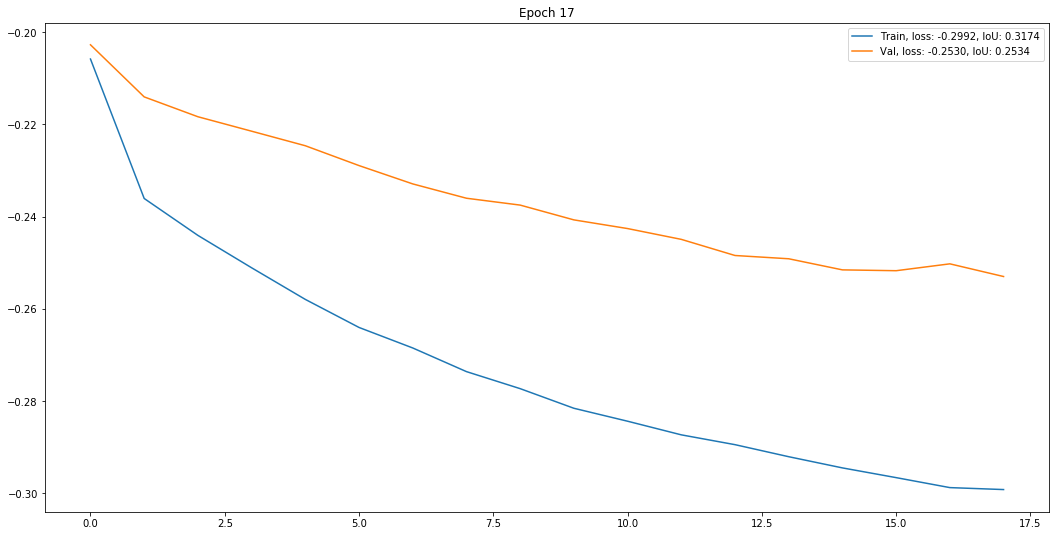

 Epoch: 18 of 70, Iter.: 44 of 44, Loss: -0.301143, Val. Loss: -0.254518
 Epoch: 18 of 70, Iter.: 44 of 44, IoU: 0.317602, Val. IoU: 0.254029


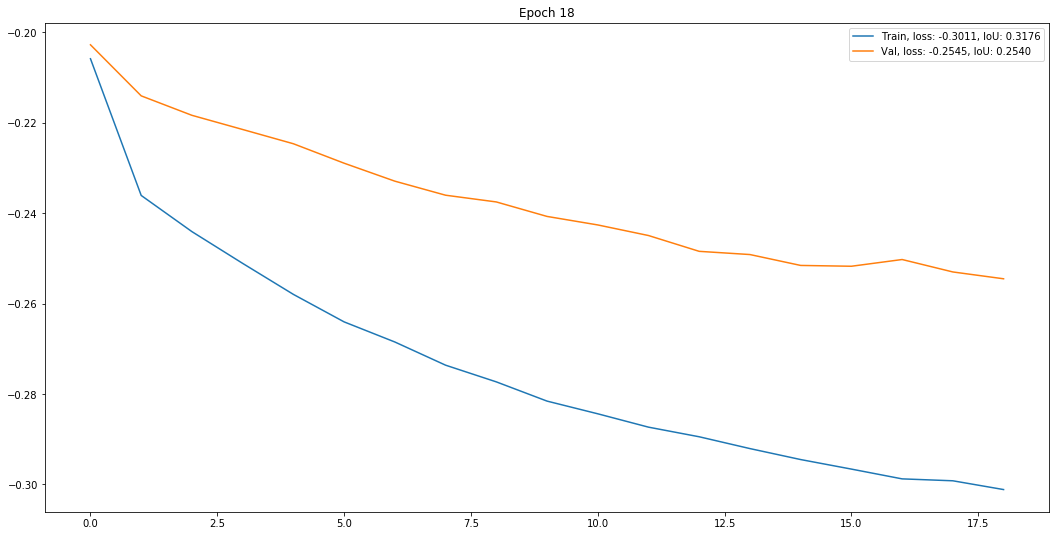

 Epoch: 19 of 70, Iter.: 44 of 44, Loss: -0.303298, Val. Loss: -0.253423
 Epoch: 19 of 70, Iter.: 44 of 44, IoU: 0.318588, Val. IoU: 0.249229


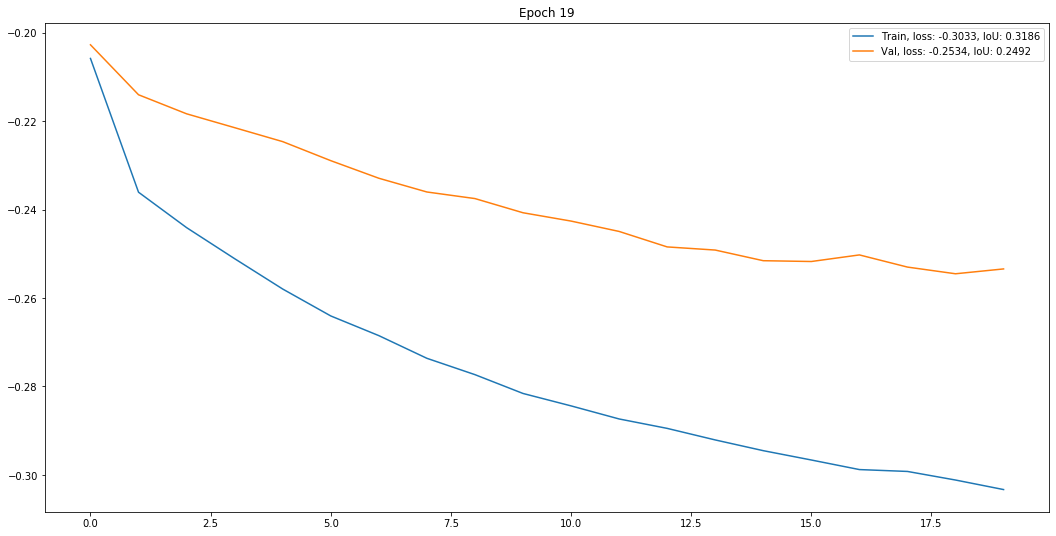

 Epoch: 20 of 70, Iter.: 44 of 44, Loss: -0.304698, Val. Loss: -0.255664
 Epoch: 20 of 70, Iter.: 44 of 44, IoU: 0.318551, Val. IoU: 0.252471


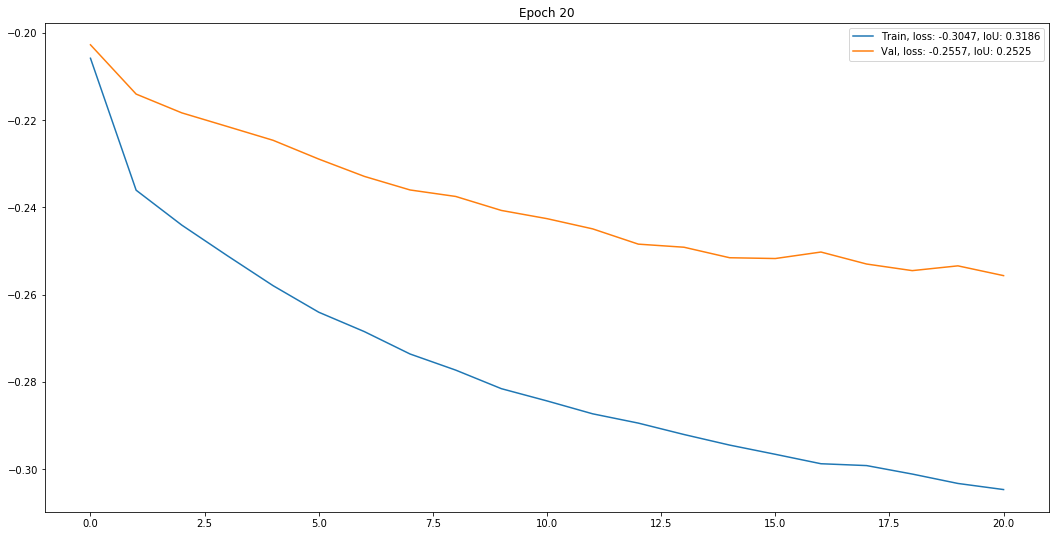

 Epoch: 21 of 70, Iter.: 44 of 44, Loss: -0.305892, Val. Loss: -0.252906
 Epoch: 21 of 70, Iter.: 44 of 44, IoU: 0.318705, Val. IoU: 0.244022


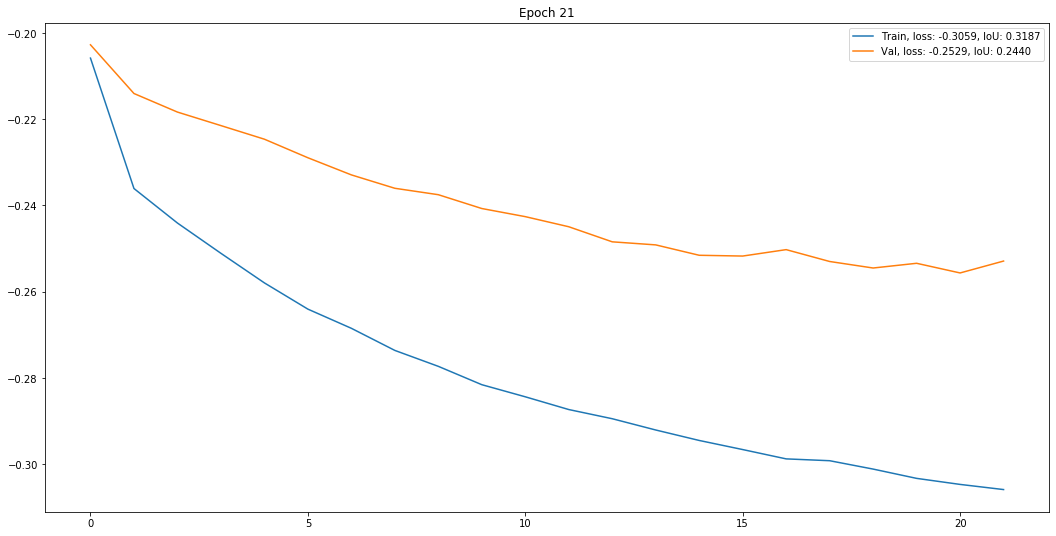

 Epoch: 22 of 70, Iter.: 44 of 44, Loss: -0.306833, Val. Loss: -0.254395
 Epoch: 22 of 70, Iter.: 44 of 44, IoU: 0.318758, Val. IoU: 0.243491


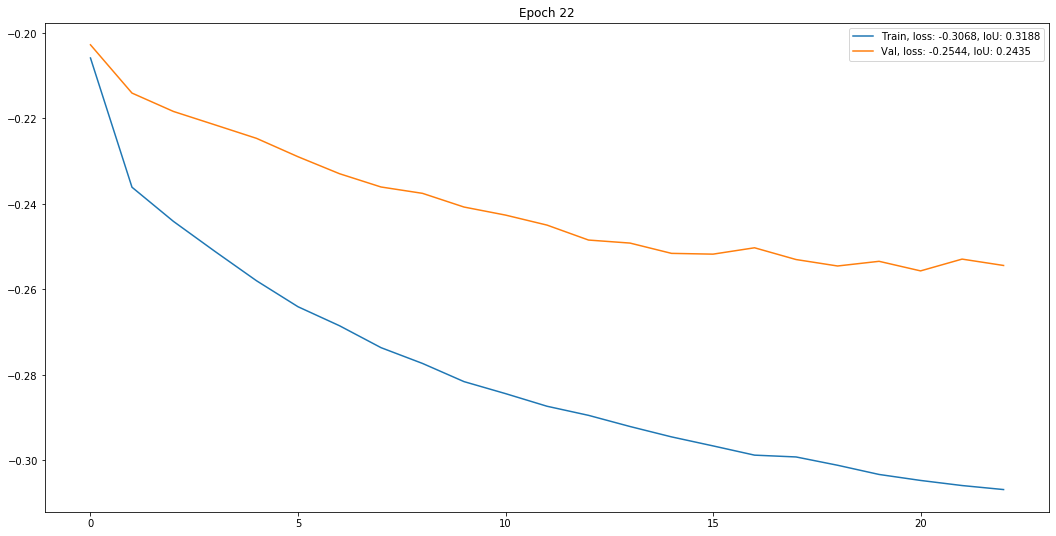

 Epoch: 23 of 70, Iter.: 44 of 44, Loss: -0.309002, Val. Loss: -0.260353
 Epoch: 23 of 70, Iter.: 44 of 44, IoU: 0.319854, Val. IoU: 0.253057


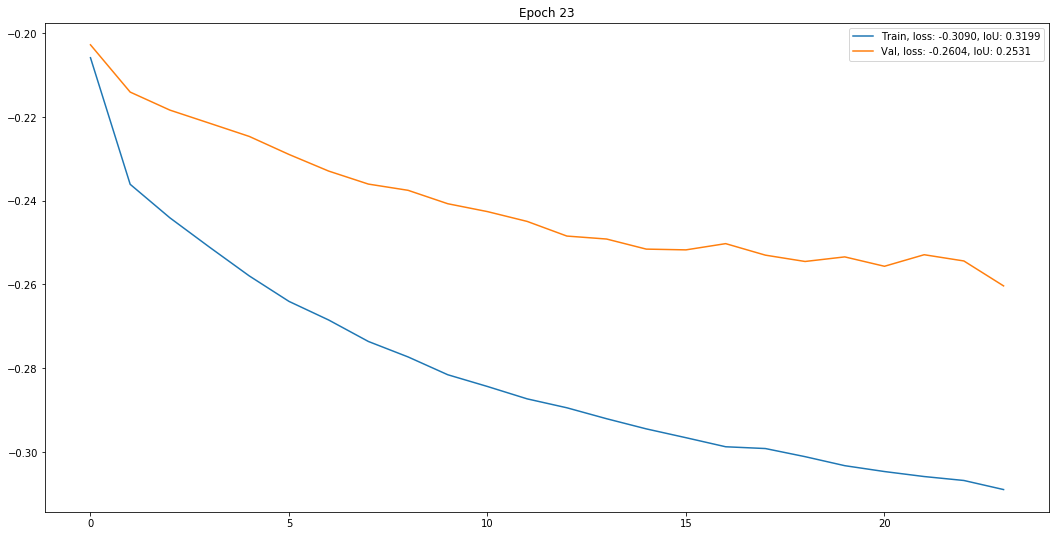

 Epoch: 24 of 70, Iter.: 44 of 44, Loss: -0.309466, Val. Loss: -0.262893
 Epoch: 24 of 70, Iter.: 44 of 44, IoU: 0.319534, Val. IoU: 0.254048


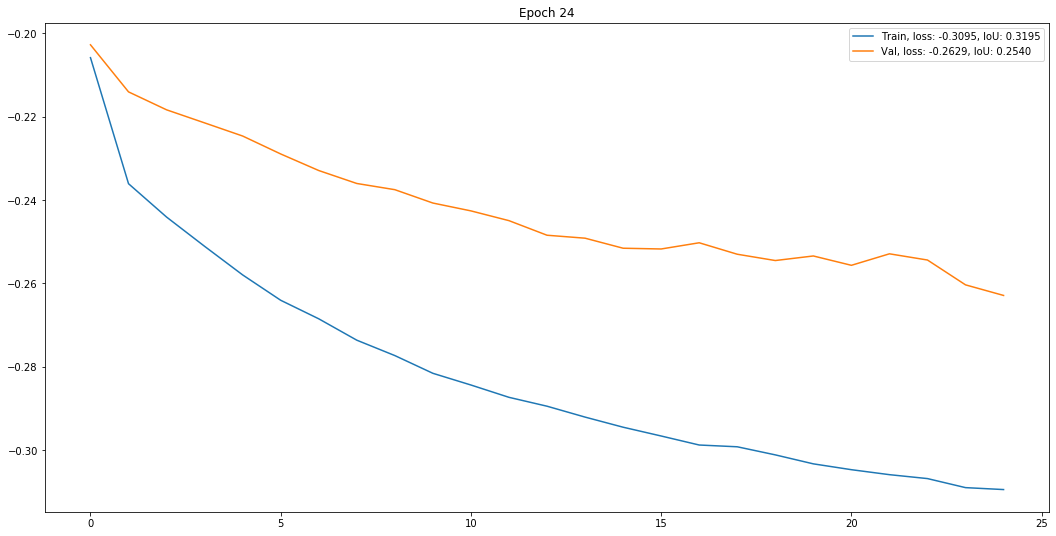

 Epoch: 25 of 70, Iter.: 44 of 44, Loss: -0.311481, Val. Loss: -0.257068
 Epoch: 25 of 70, Iter.: 44 of 44, IoU: 0.321051, Val. IoU: 0.243092


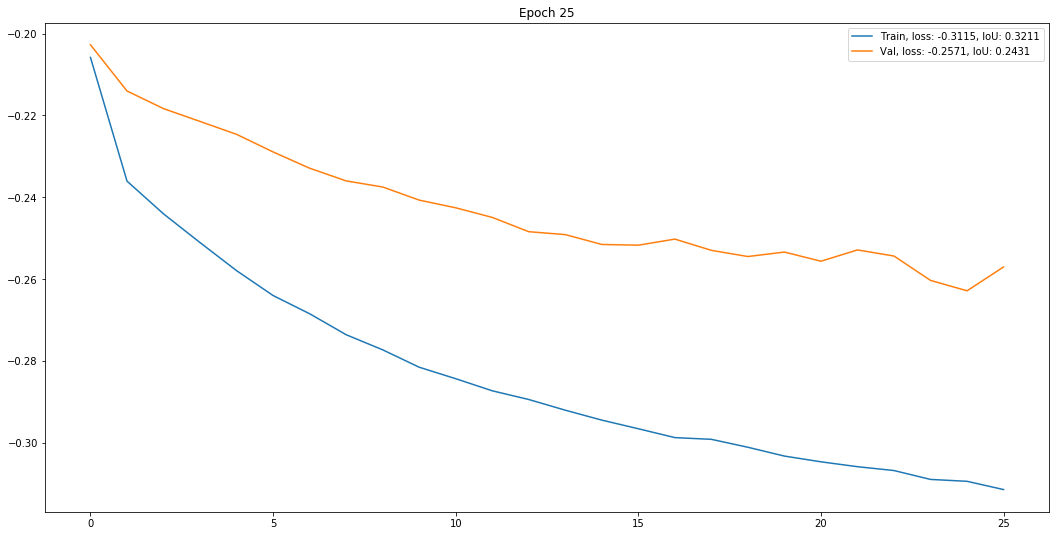

 Epoch: 26 of 70, Iter.: 44 of 44, Loss: -0.311974, Val. Loss: -0.263413
 Epoch: 26 of 70, Iter.: 44 of 44, IoU: 0.320958, Val. IoU: 0.252312


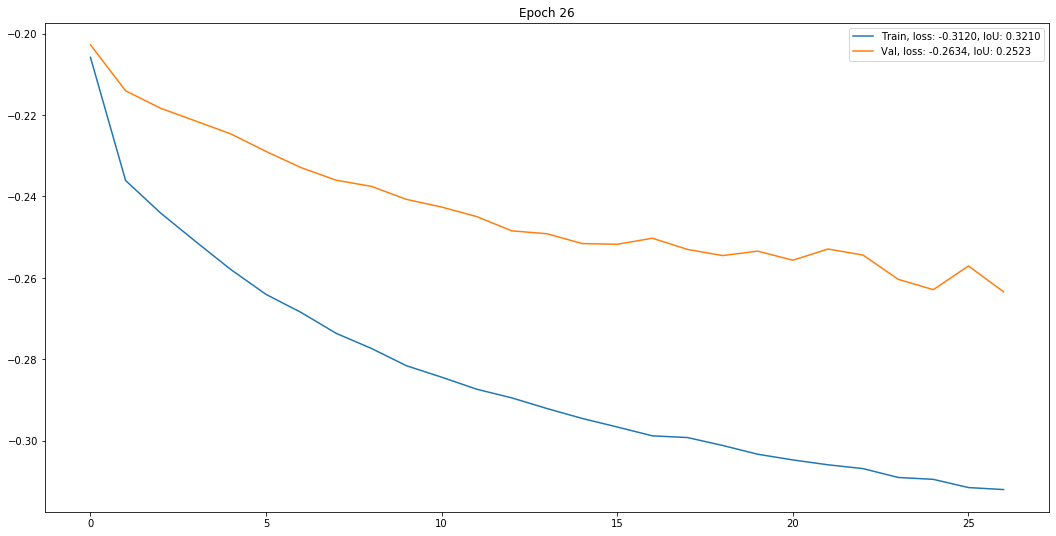

 Epoch: 27 of 70, Iter.: 44 of 44, Loss: -0.313842, Val. Loss: -0.253562
 Epoch: 27 of 70, Iter.: 44 of 44, IoU: 0.321213, Val. IoU: 0.236996


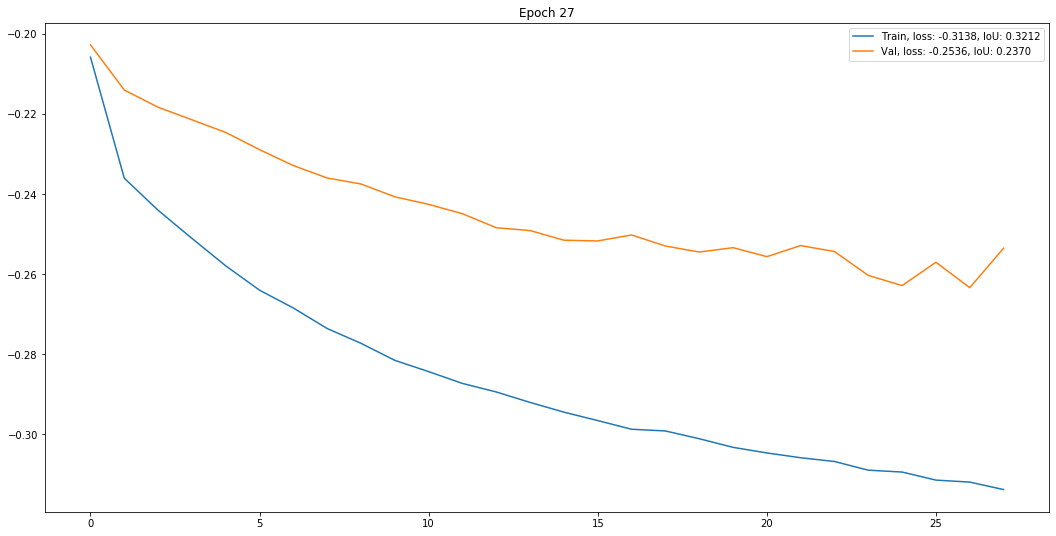

 Epoch: 28 of 70, Iter.: 44 of 44, Loss: -0.314089, Val. Loss: -0.273066
 Epoch: 28 of 70, Iter.: 44 of 44, IoU: 0.321155, Val. IoU: 0.267594


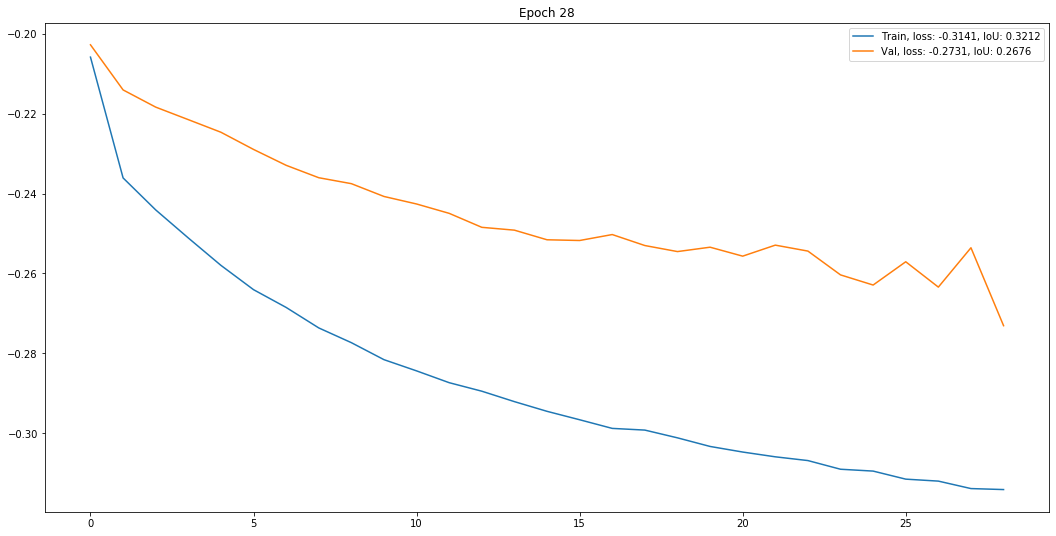

 Epoch: 29 of 70, Iter.: 44 of 44, Loss: -0.314974, Val. Loss: -0.265818
 Epoch: 29 of 70, Iter.: 44 of 44, IoU: 0.321299, Val. IoU: 0.252706


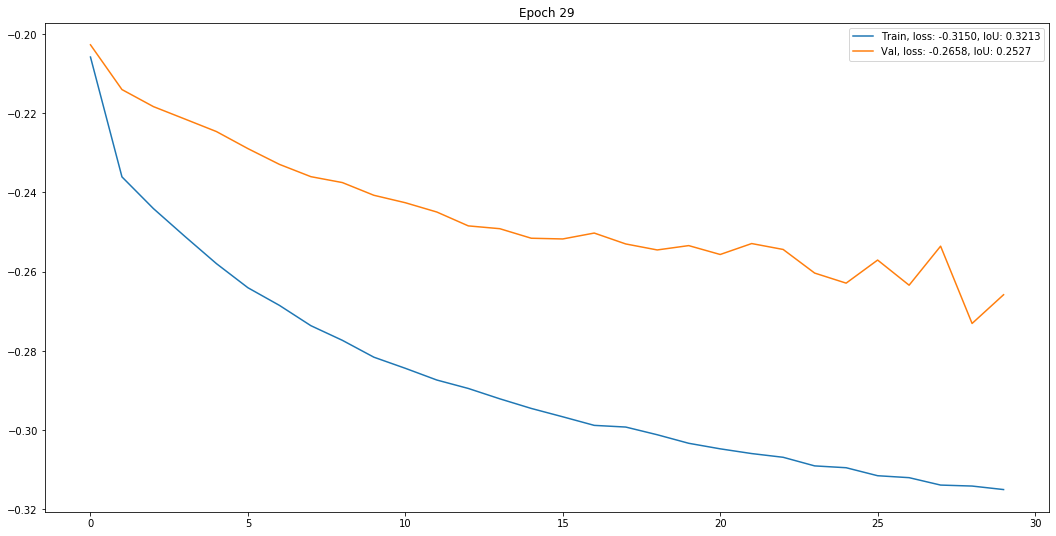

 Epoch: 30 of 70, Iter.: 44 of 44, Loss: -0.316642, Val. Loss: -0.269108
 Epoch: 30 of 70, Iter.: 44 of 44, IoU: 0.322037, Val. IoU: 0.257183


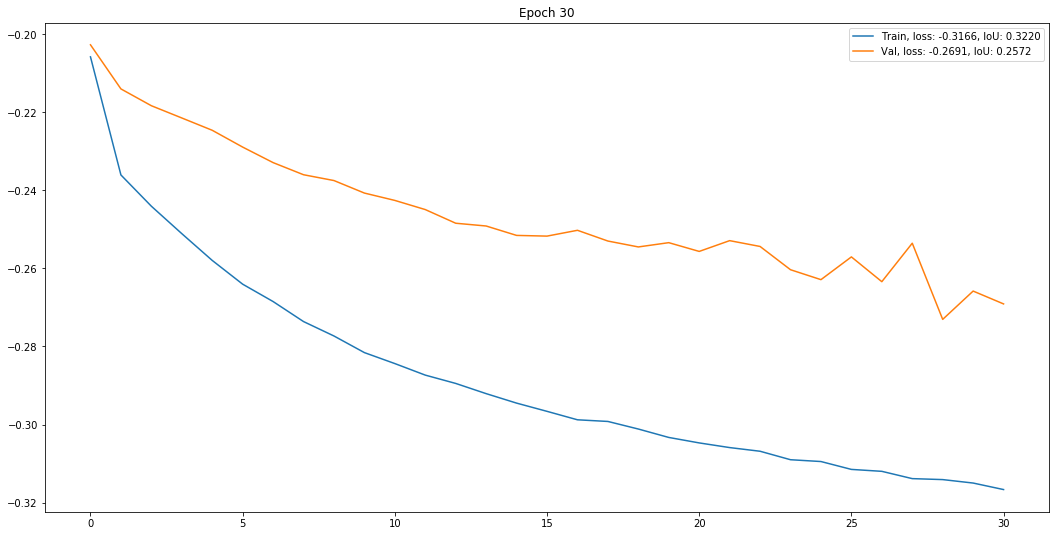

 Epoch: 31 of 70, Iter.: 44 of 44, Loss: -0.317643, Val. Loss: -0.265360
 Epoch: 31 of 70, Iter.: 44 of 44, IoU: 0.322190, Val. IoU: 0.250734


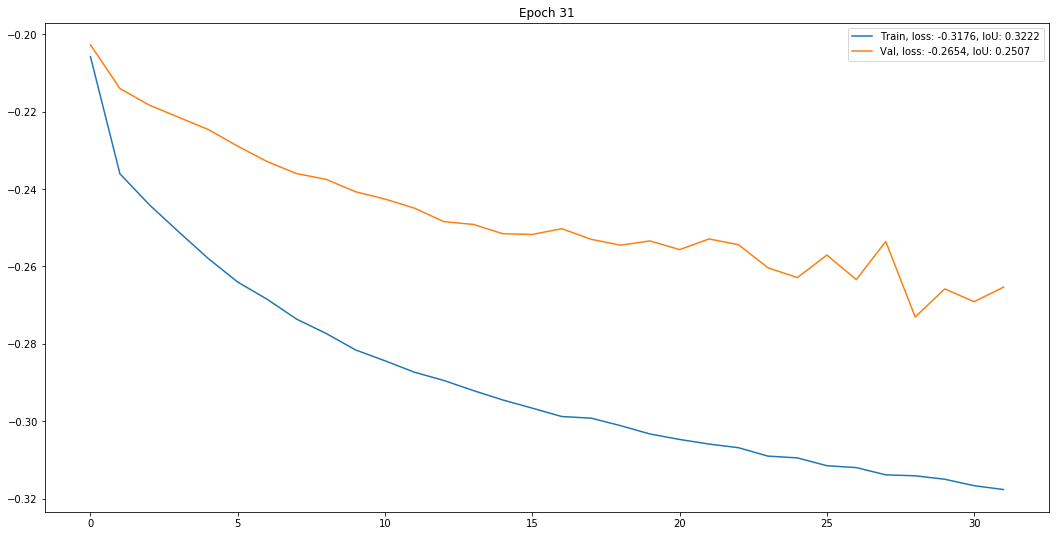

 Epoch: 32 of 70, Iter.: 44 of 44, Loss: -0.317451, Val. Loss: -0.272163
 Epoch: 32 of 70, Iter.: 44 of 44, IoU: 0.321948, Val. IoU: 0.260892


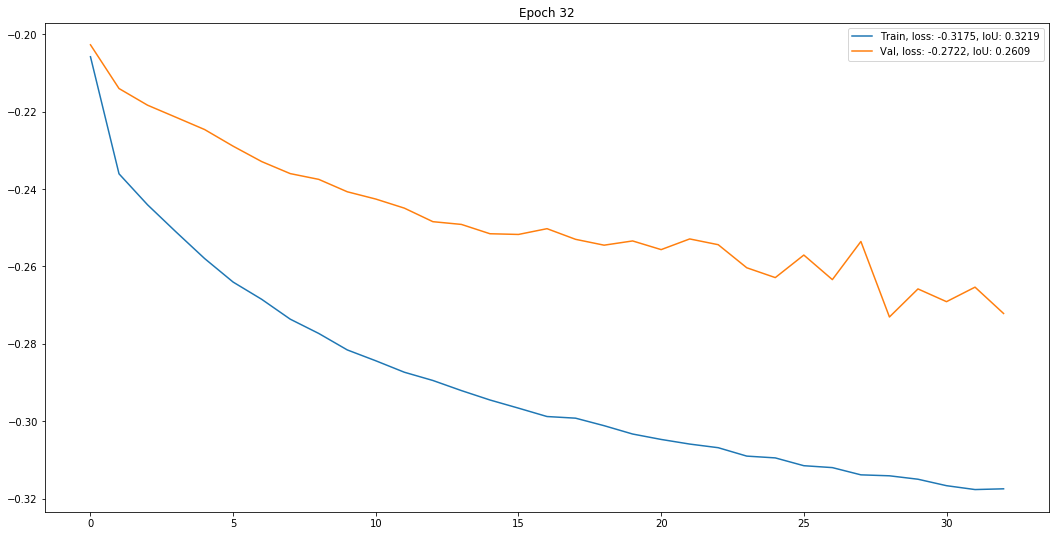

 Epoch: 33 of 70, Iter.: 44 of 44, Loss: -0.318190, Val. Loss: -0.265895
 Epoch: 33 of 70, Iter.: 44 of 44, IoU: 0.321981, Val. IoU: 0.249593


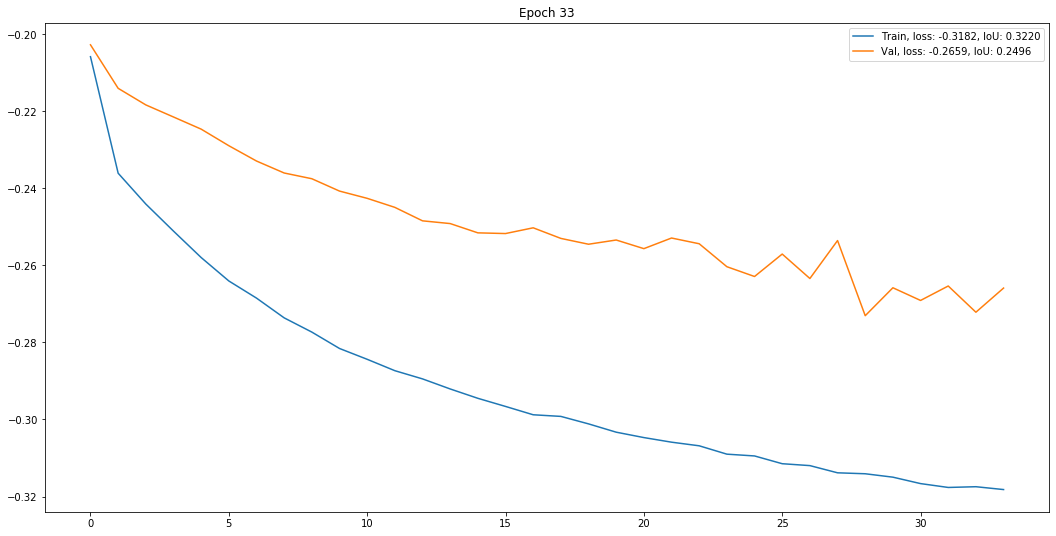

 Epoch: 34 of 70, Iter.: 44 of 44, Loss: -0.319612, Val. Loss: -0.277719
 Epoch: 34 of 70, Iter.: 44 of 44, IoU: 0.323146, Val. IoU: 0.265943


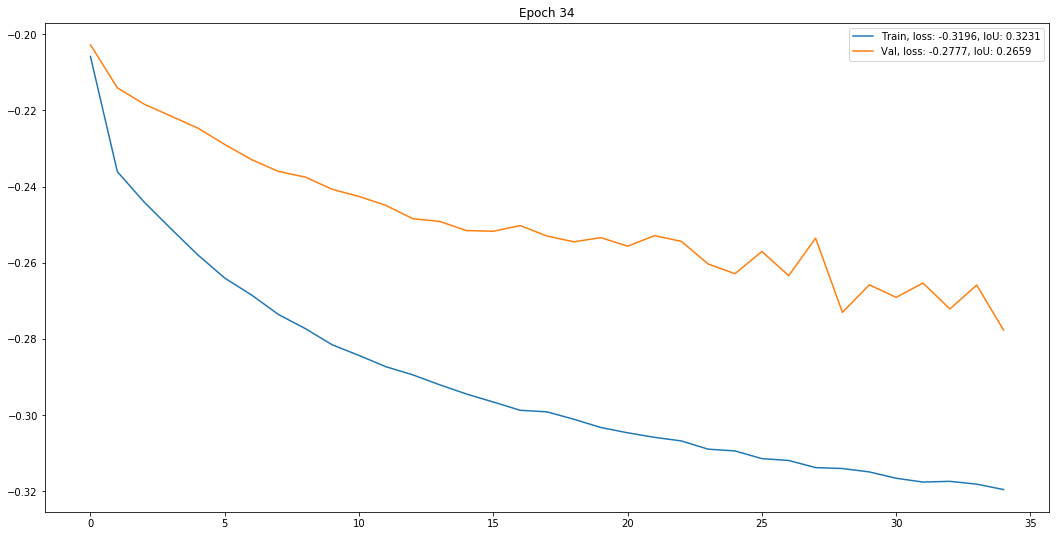

 Epoch: 35 of 70, Iter.: 44 of 44, Loss: -0.320619, Val. Loss: -0.269437
 Epoch: 35 of 70, Iter.: 44 of 44, IoU: 0.323795, Val. IoU: 0.254073


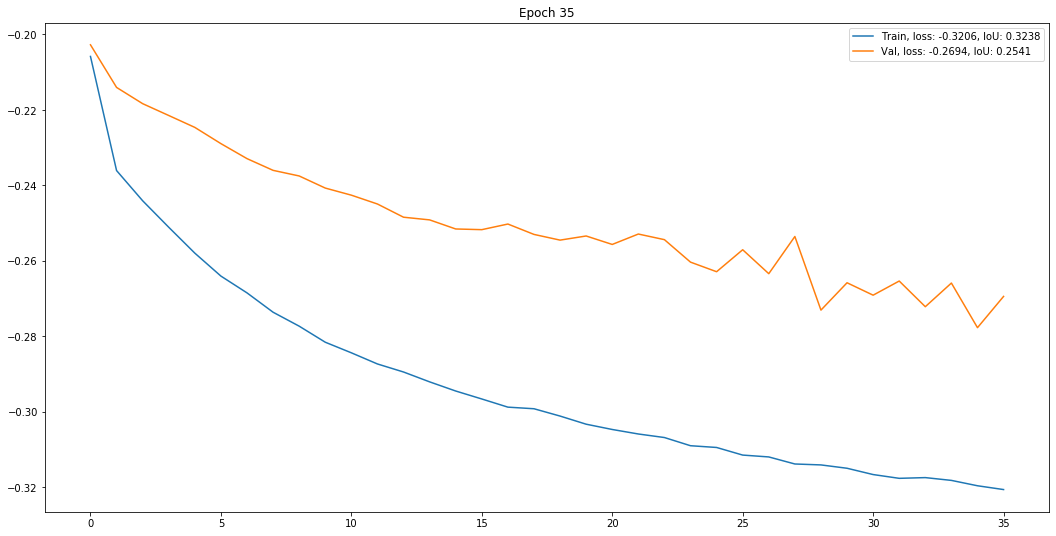

 Epoch: 36 of 70, Iter.: 44 of 44, Loss: -0.320359, Val. Loss: -0.269048
 Epoch: 36 of 70, Iter.: 44 of 44, IoU: 0.323699, Val. IoU: 0.252521


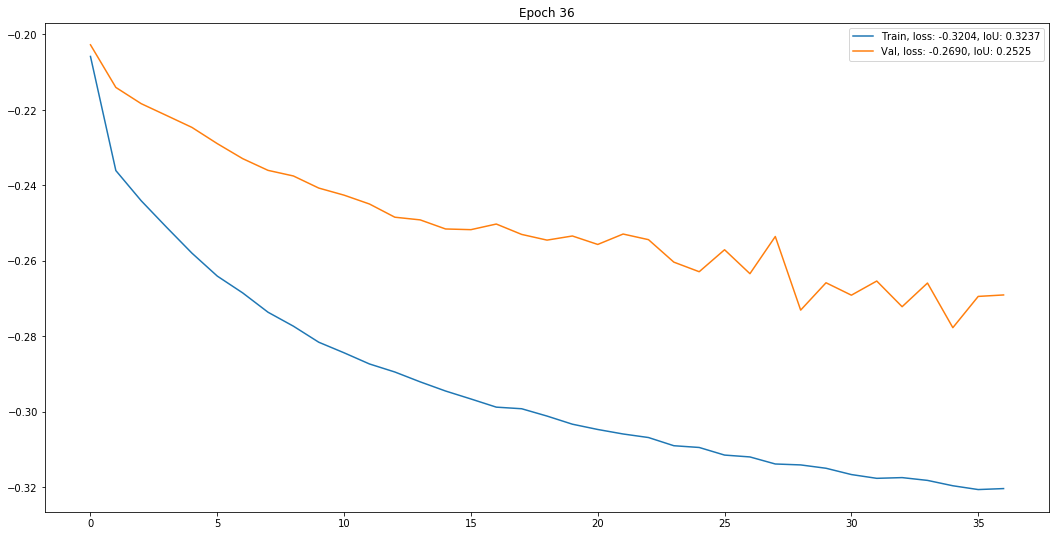

 Epoch: 37 of 70, Iter.: 44 of 44, Loss: -0.321602, Val. Loss: -0.278928
 Epoch: 37 of 70, Iter.: 44 of 44, IoU: 0.324179, Val. IoU: 0.269893


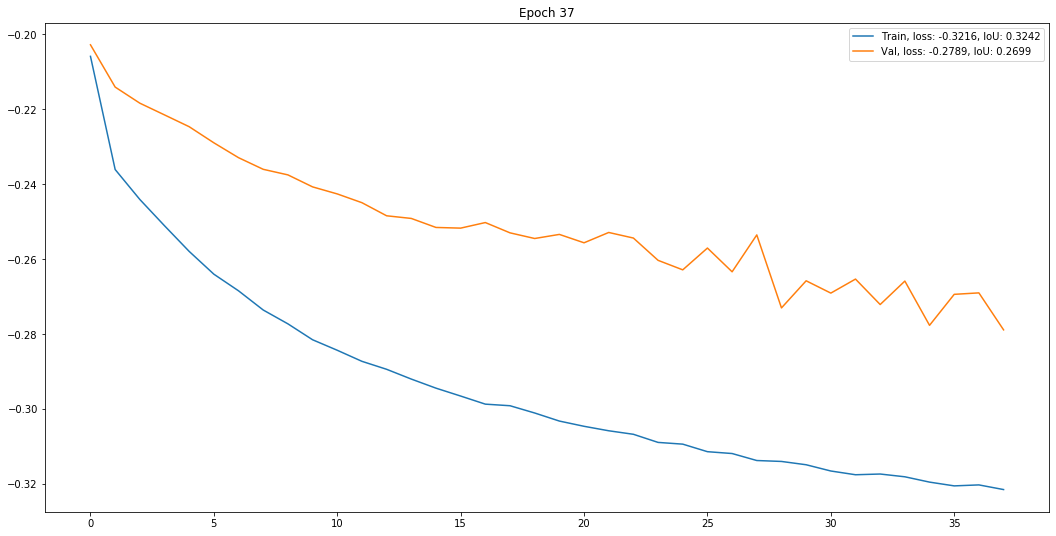

 Epoch: 38 of 70, Iter.: 44 of 44, Loss: -0.321956, Val. Loss: -0.274521
 Epoch: 38 of 70, Iter.: 44 of 44, IoU: 0.324402, Val. IoU: 0.261233


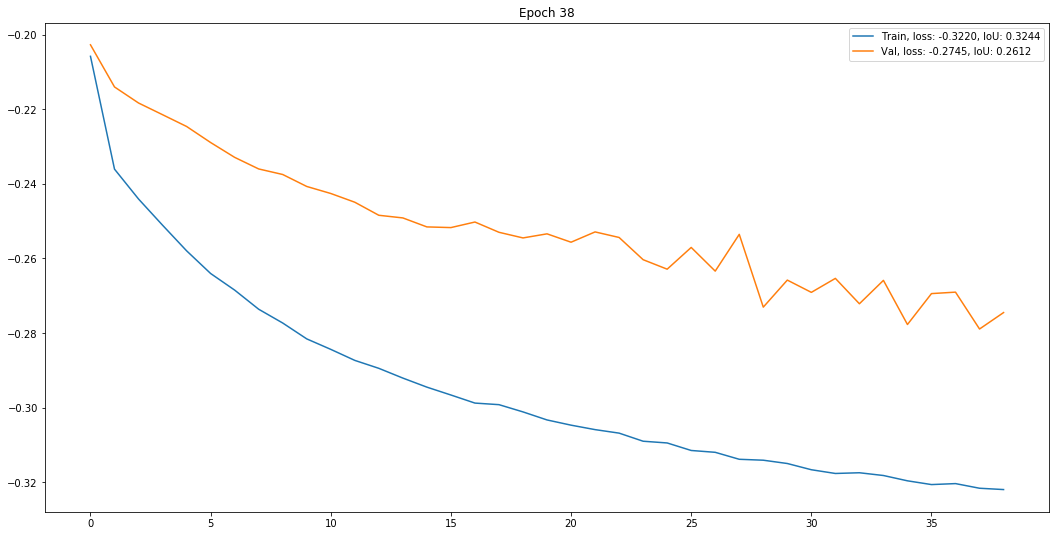

 Epoch: 39 of 70, Iter.: 44 of 44, Loss: -0.323236, Val. Loss: -0.280802
 Epoch: 39 of 70, Iter.: 44 of 44, IoU: 0.325142, Val. IoU: 0.268251


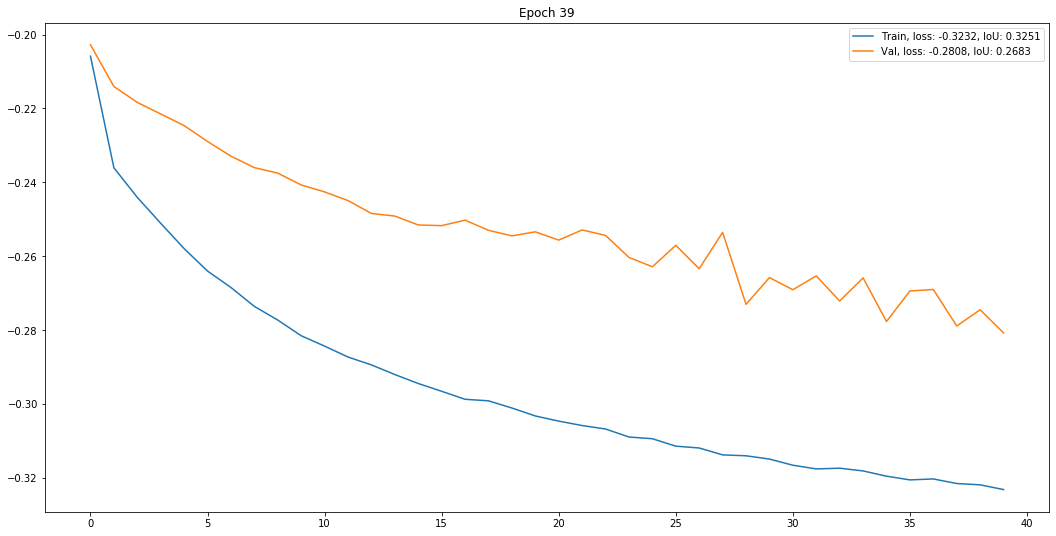

 Epoch: 40 of 70, Iter.: 44 of 44, Loss: -0.323969, Val. Loss: -0.275884
 Epoch: 40 of 70, Iter.: 44 of 44, IoU: 0.324895, Val. IoU: 0.259537


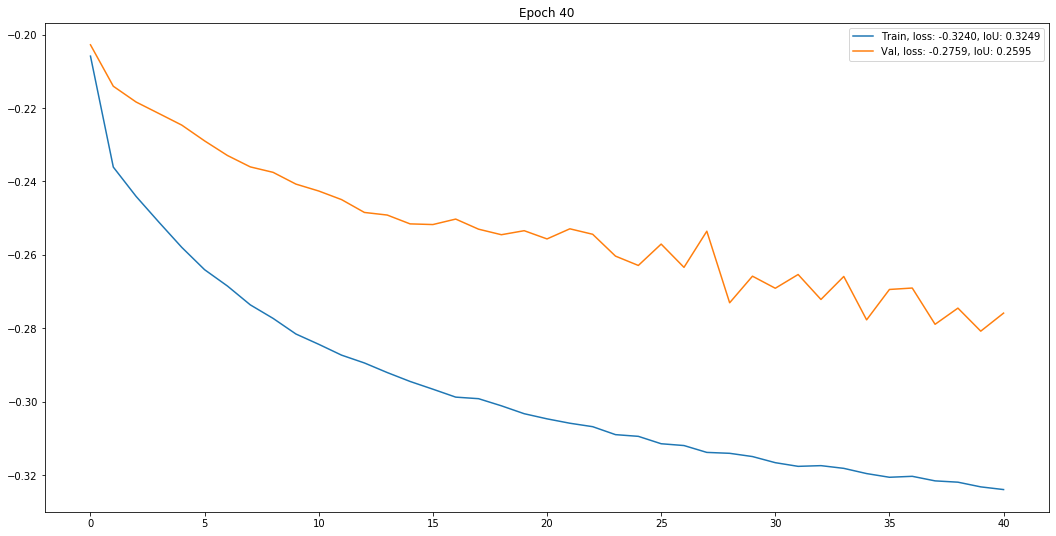

 Epoch: 41 of 70, Iter.: 44 of 44, Loss: -0.324147, Val. Loss: -0.281965
 Epoch: 41 of 70, Iter.: 44 of 44, IoU: 0.324771, Val. IoU: 0.270255


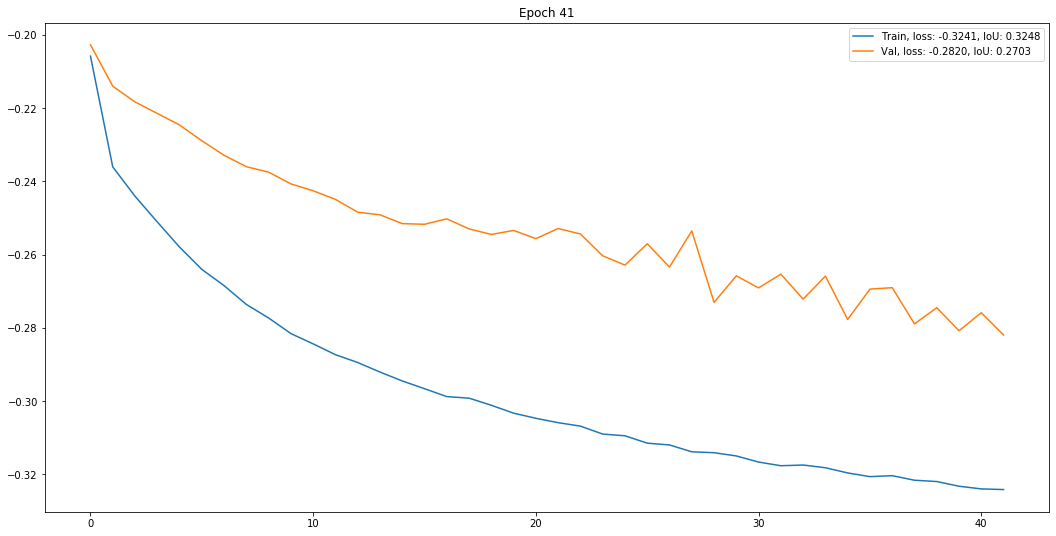

 Epoch: 42 of 70, Iter.: 44 of 44, Loss: -0.324955, Val. Loss: -0.280691
 Epoch: 42 of 70, Iter.: 44 of 44, IoU: 0.325701, Val. IoU: 0.265408


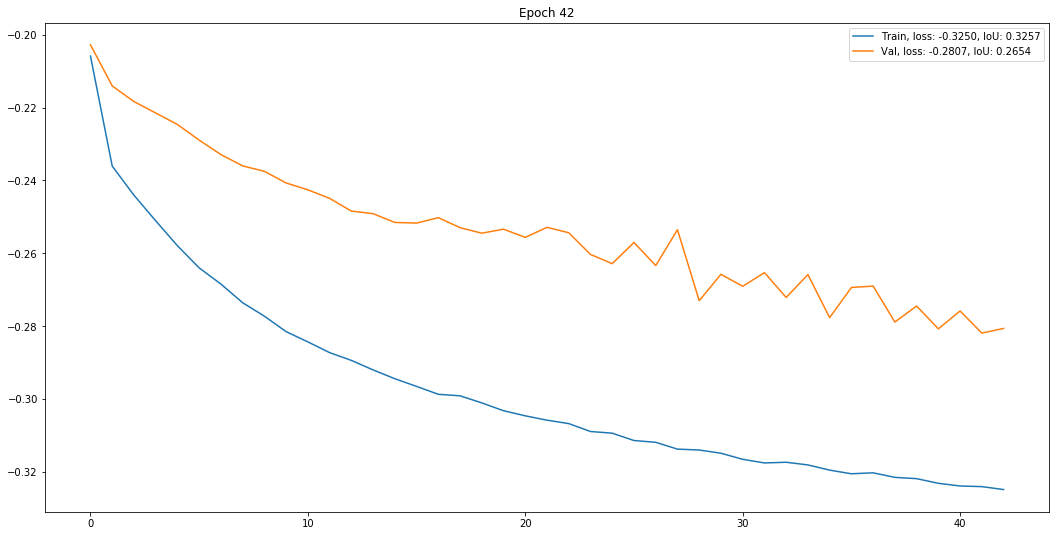

 Epoch: 43 of 70, Iter.: 44 of 44, Loss: -0.325156, Val. Loss: -0.283437
 Epoch: 43 of 70, Iter.: 44 of 44, IoU: 0.325801, Val. IoU: 0.268570


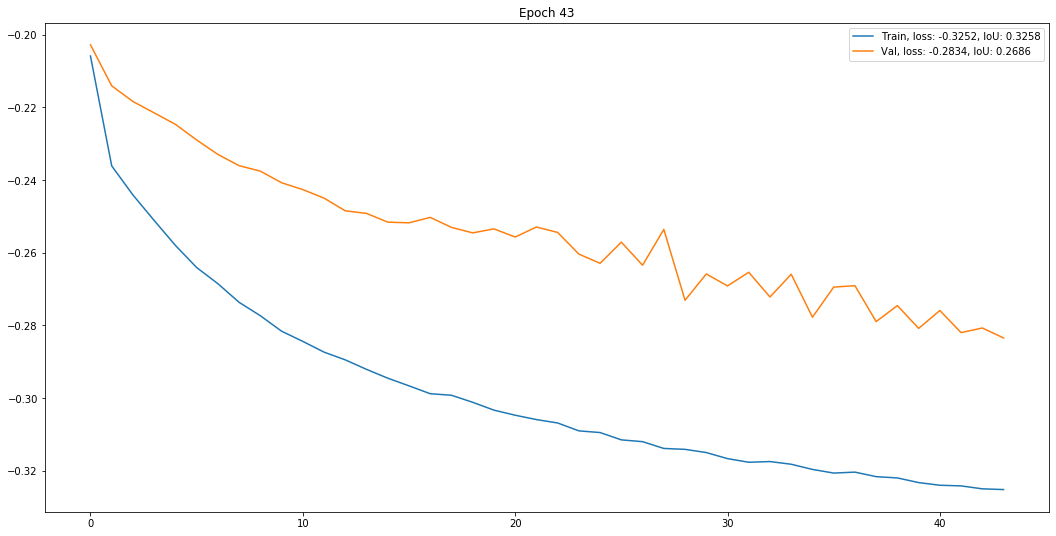

 Epoch: 44 of 70, Iter.: 44 of 44, Loss: -0.325818, Val. Loss: -0.285503
 Epoch: 44 of 70, Iter.: 44 of 44, IoU: 0.325724, Val. IoU: 0.272740


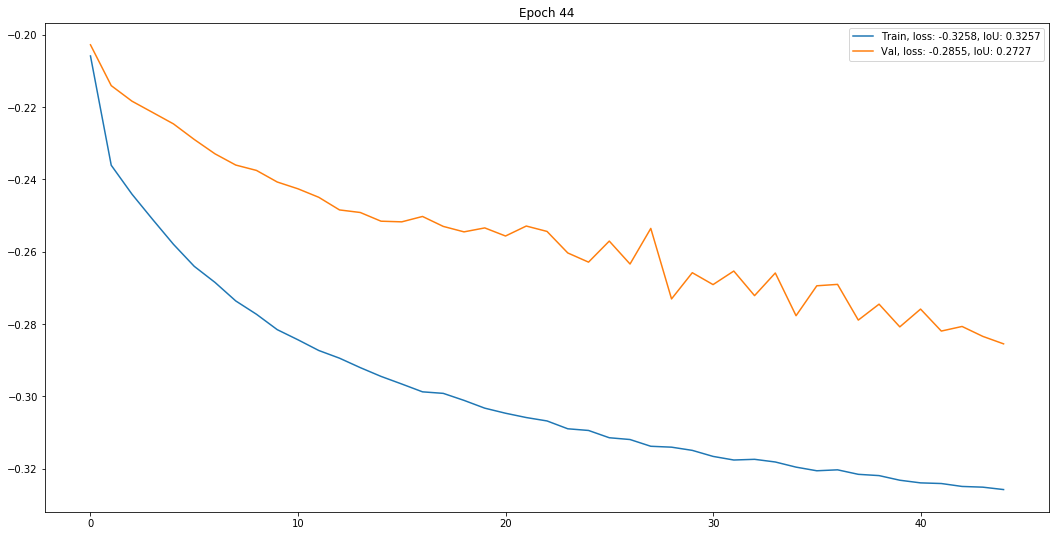

 Epoch: 45 of 70, Iter.: 44 of 44, Loss: -0.326927, Val. Loss: -0.284055
 Epoch: 45 of 70, Iter.: 44 of 44, IoU: 0.326242, Val. IoU: 0.270310


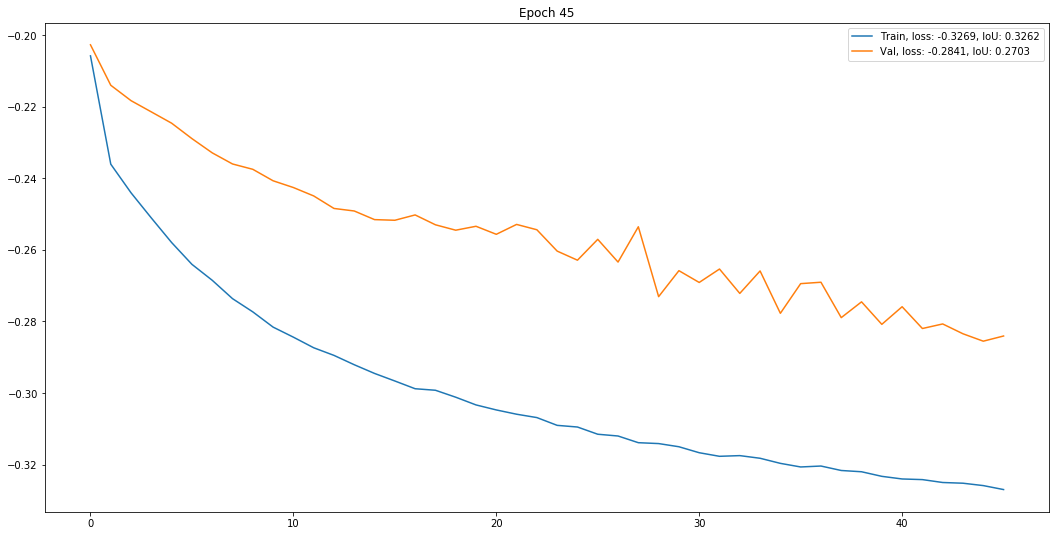

 Epoch: 46 of 70, Iter.: 44 of 44, Loss: -0.327093, Val. Loss: -0.287551
 Epoch: 46 of 70, Iter.: 44 of 44, IoU: 0.326900, Val. IoU: 0.274346


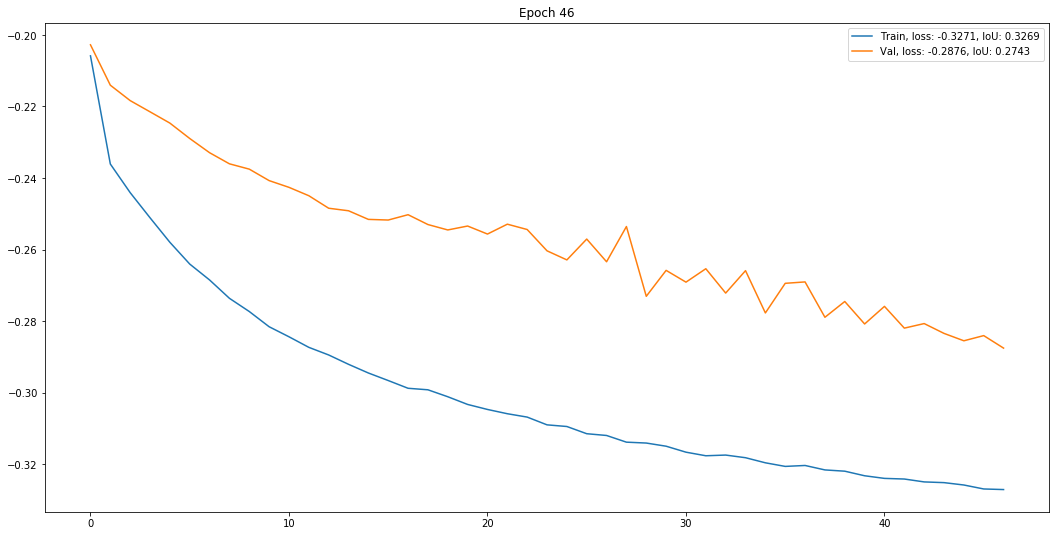

 Epoch: 47 of 70, Iter.: 44 of 44, Loss: -0.327983, Val. Loss: -0.281761
 Epoch: 47 of 70, Iter.: 44 of 44, IoU: 0.327220, Val. IoU: 0.267526


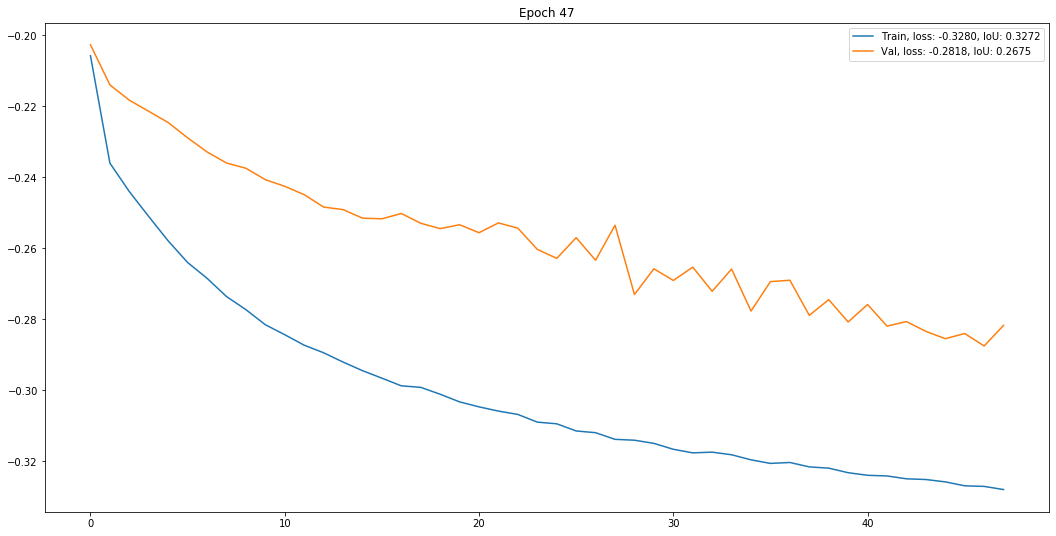

 Epoch: 48 of 70, Iter.: 44 of 44, Loss: -0.327776, Val. Loss: -0.285579
 Epoch: 48 of 70, Iter.: 44 of 44, IoU: 0.326927, Val. IoU: 0.272061


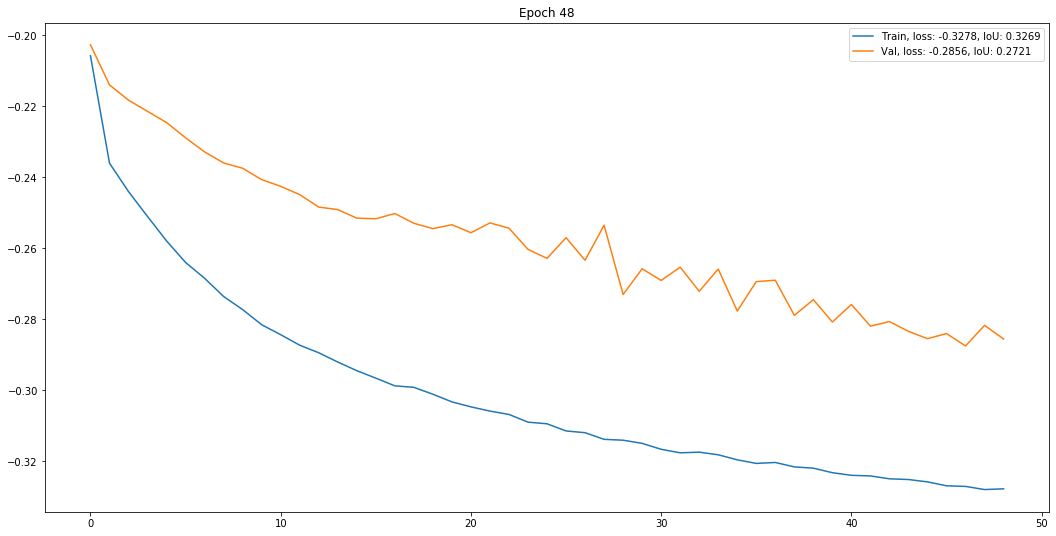

 Epoch: 49 of 70, Iter.: 44 of 44, Loss: -0.327889, Val. Loss: -0.284126
 Epoch: 49 of 70, Iter.: 44 of 44, IoU: 0.326809, Val. IoU: 0.271224


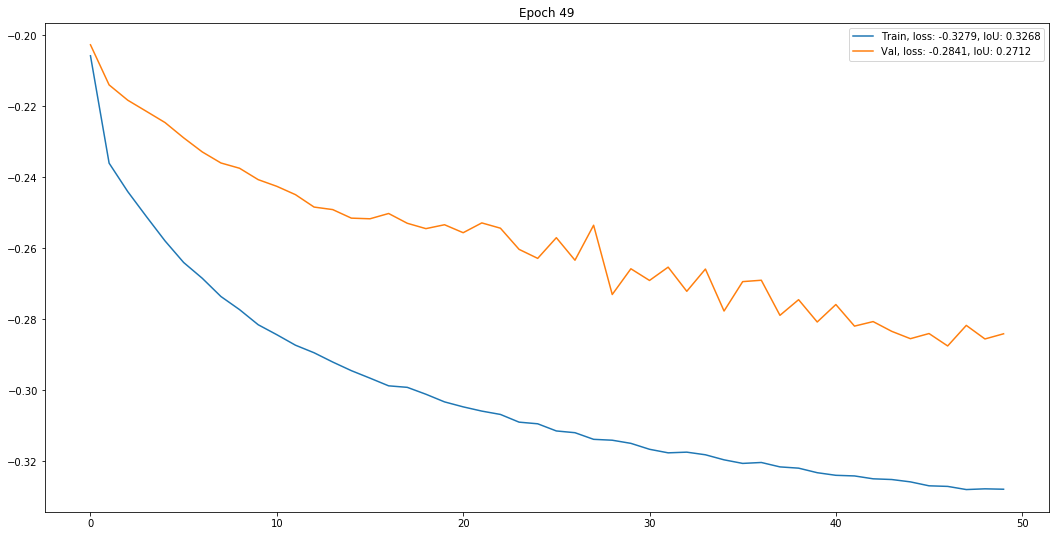

 Epoch: 50 of 70, Iter.: 44 of 44, Loss: -0.328221, Val. Loss: -0.289153
 Epoch: 50 of 70, Iter.: 44 of 44, IoU: 0.326975, Val. IoU: 0.276460


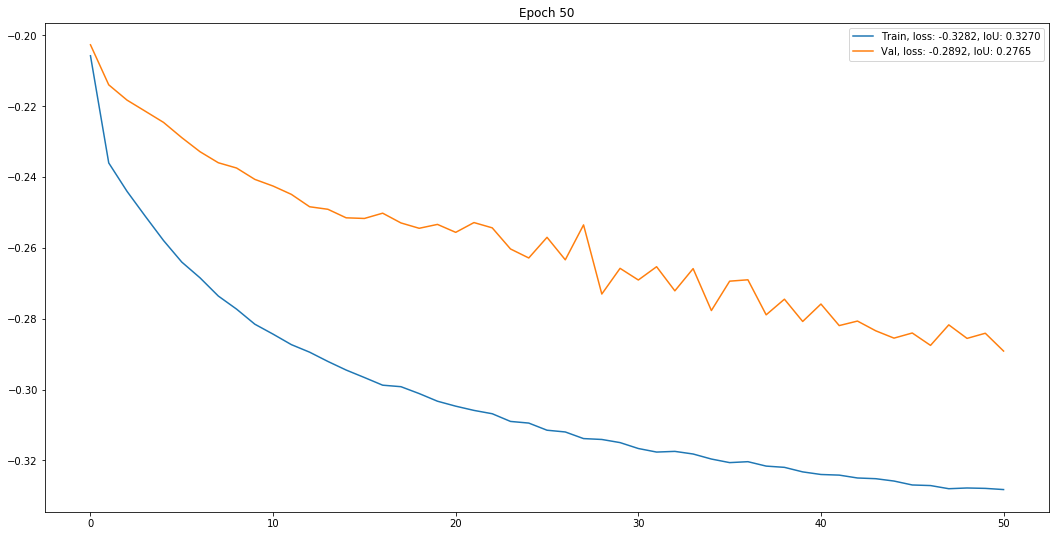

 Epoch: 51 of 70, Iter.: 44 of 44, Loss: -0.329638, Val. Loss: -0.288100
 Epoch: 51 of 70, Iter.: 44 of 44, IoU: 0.327596, Val. IoU: 0.274487


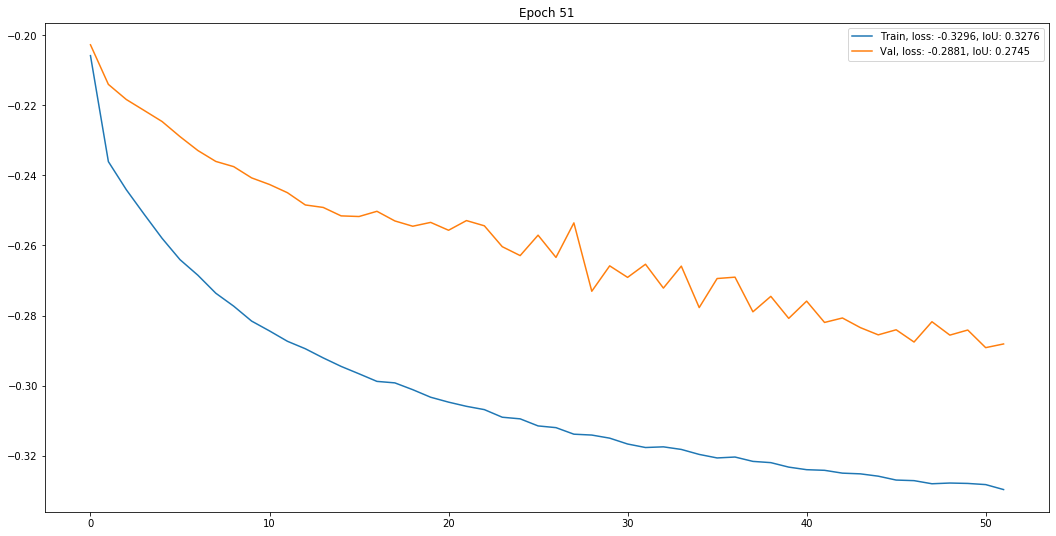

 Epoch: 52 of 70, Iter.: 44 of 44, Loss: -0.329528, Val. Loss: -0.289400
 Epoch: 52 of 70, Iter.: 44 of 44, IoU: 0.327848, Val. IoU: 0.275769


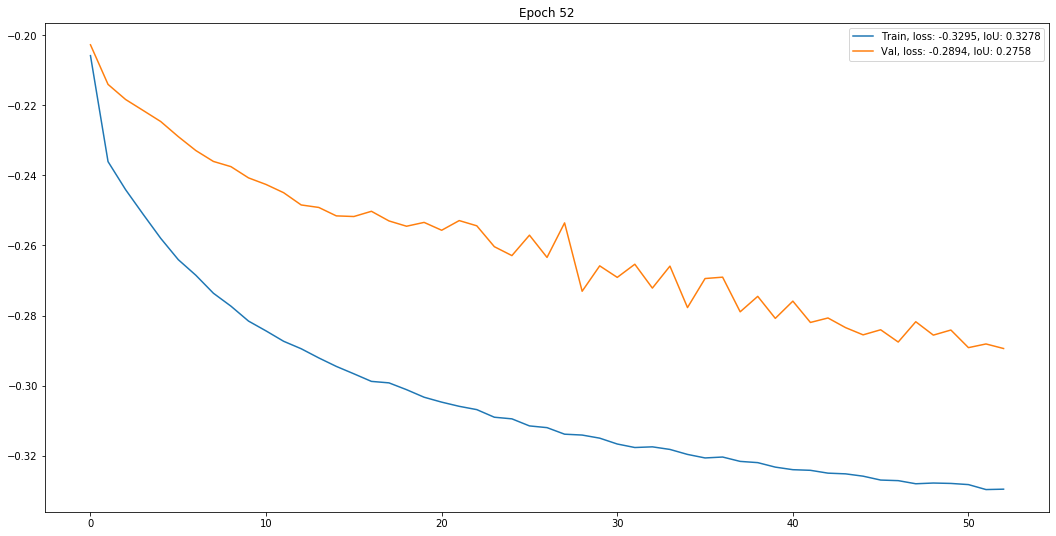

 Epoch: 53 of 70, Iter.: 44 of 44, Loss: -0.330538, Val. Loss: -0.287153
 Epoch: 53 of 70, Iter.: 44 of 44, IoU: 0.328174, Val. IoU: 0.272267


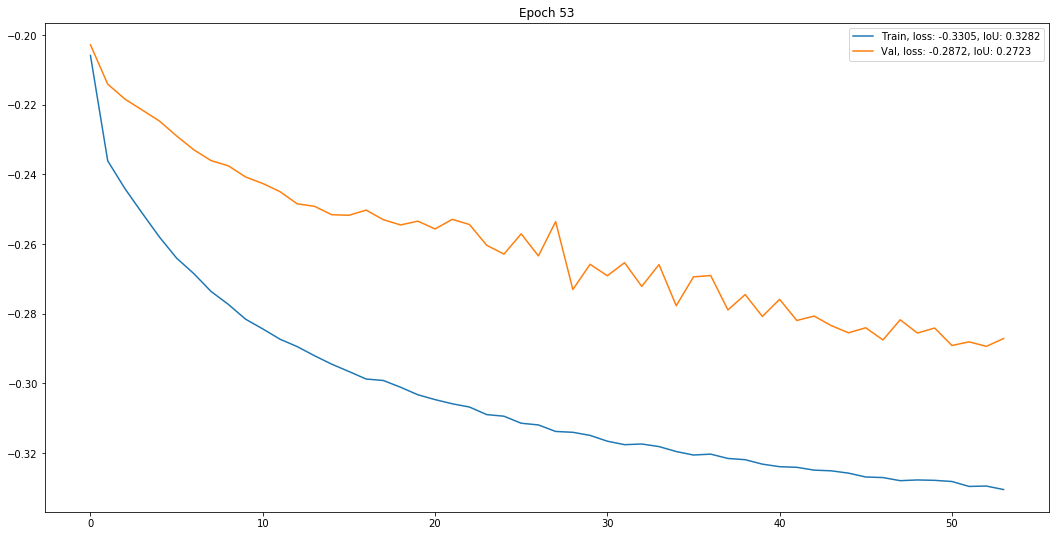

 Epoch: 54 of 70, Iter.: 44 of 44, Loss: -0.330259, Val. Loss: -0.289854
 Epoch: 54 of 70, Iter.: 44 of 44, IoU: 0.328260, Val. IoU: 0.275067


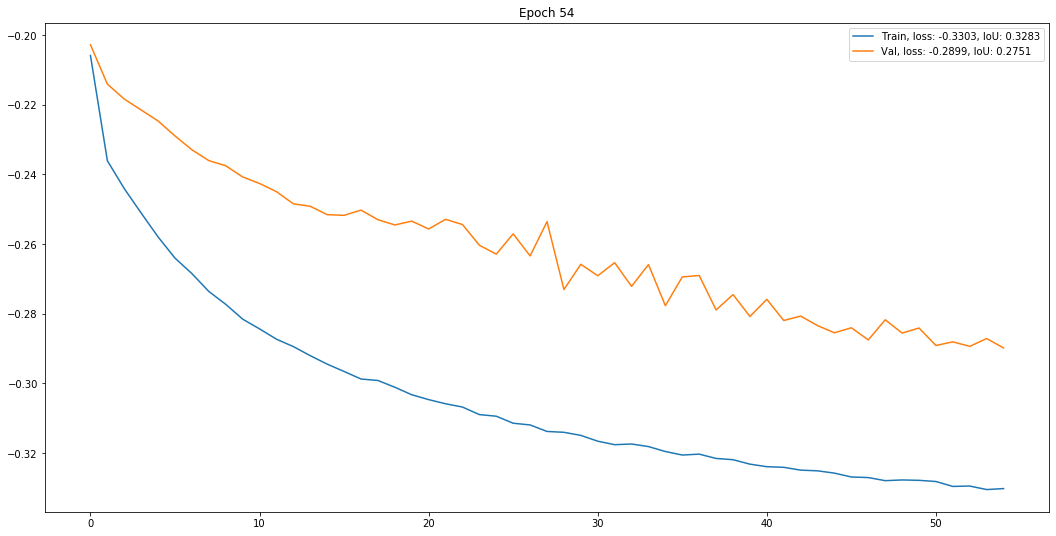

 Epoch: 55 of 70, Iter.: 44 of 44, Loss: -0.330298, Val. Loss: -0.288888
 Epoch: 55 of 70, Iter.: 44 of 44, IoU: 0.328052, Val. IoU: 0.275093


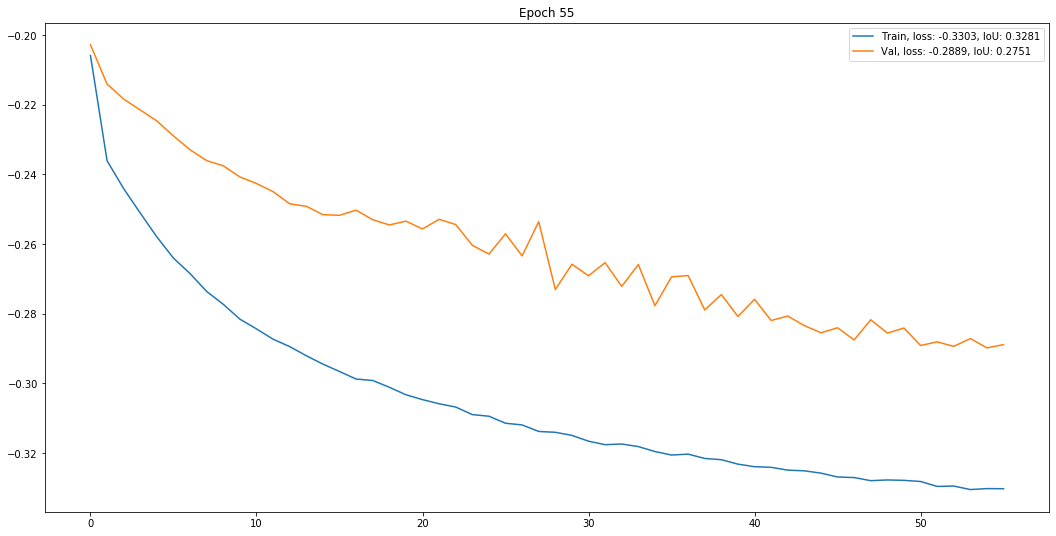

 Epoch: 56 of 70, Iter.: 44 of 44, Loss: -0.332044, Val. Loss: -0.289735
 Epoch: 56 of 70, Iter.: 44 of 44, IoU: 0.329429, Val. IoU: 0.276401


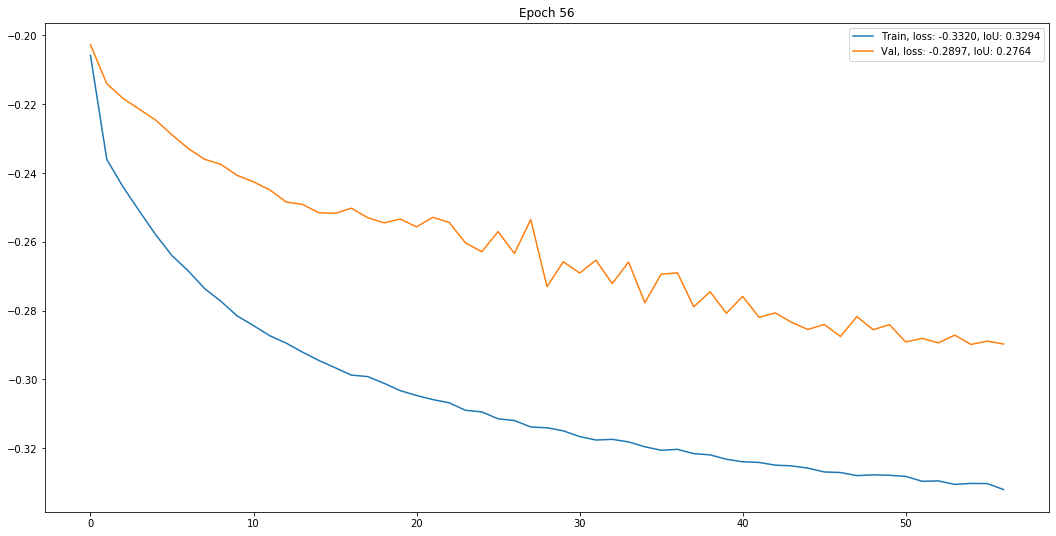

 Epoch: 57 of 70, Iter.: 44 of 44, Loss: -0.332132, Val. Loss: -0.291679
 Epoch: 57 of 70, Iter.: 44 of 44, IoU: 0.329842, Val. IoU: 0.277181


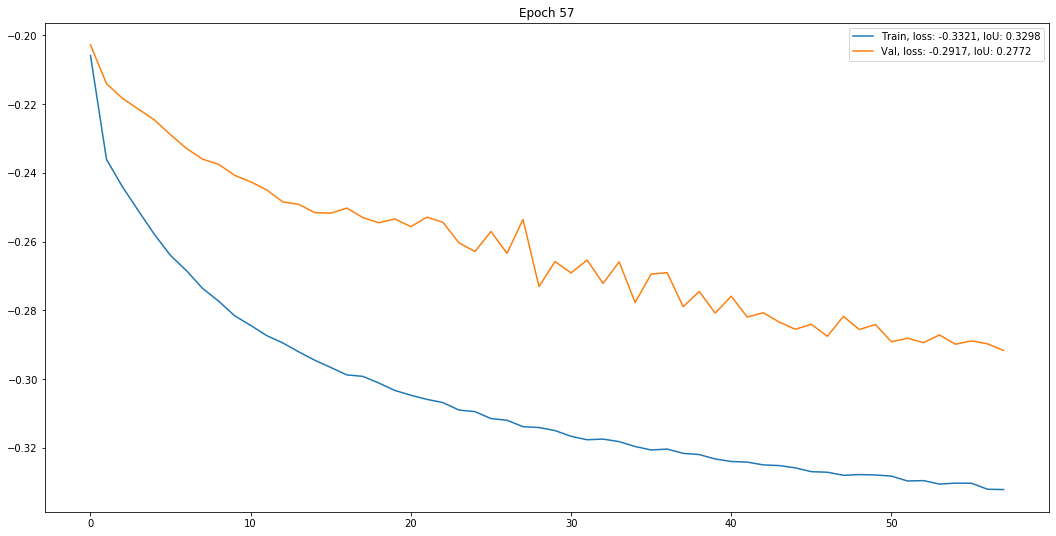

 Epoch: 58 of 70, Iter.: 44 of 44, Loss: -0.332296, Val. Loss: -0.288363
 Epoch: 58 of 70, Iter.: 44 of 44, IoU: 0.329570, Val. IoU: 0.273134


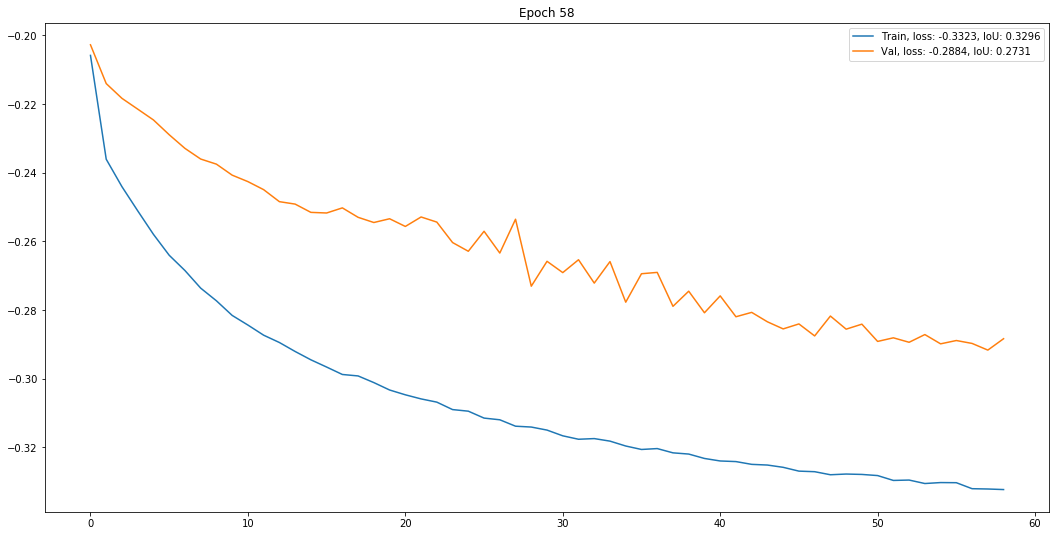

 Epoch: 59 of 70, Iter.: 44 of 44, Loss: -0.332919, Val. Loss: -0.290038
 Epoch: 59 of 70, Iter.: 44 of 44, IoU: 0.329500, Val. IoU: 0.278798


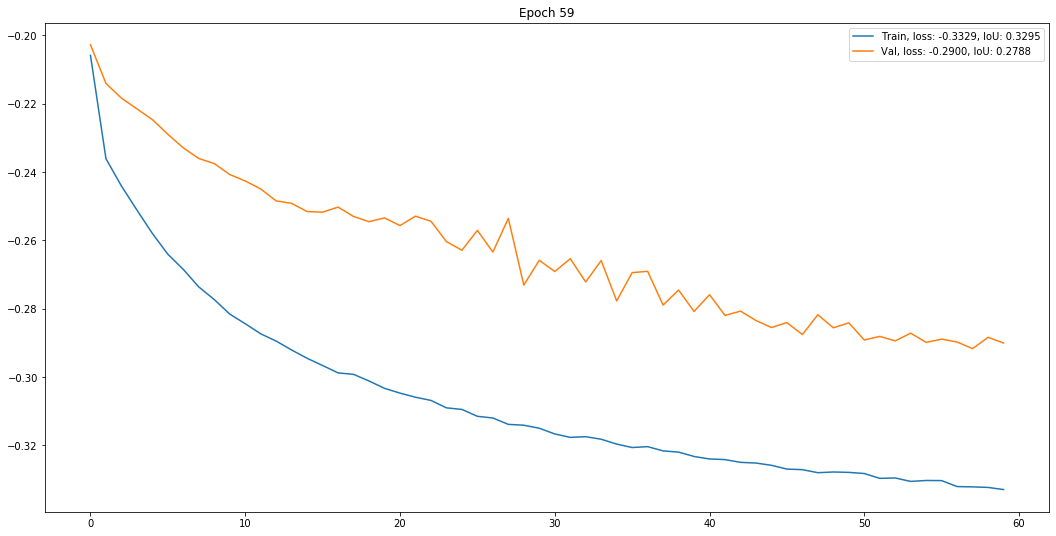

 Epoch: 60 of 70, Iter.: 44 of 44, Loss: -0.333161, Val. Loss: -0.290911
 Epoch: 60 of 70, Iter.: 44 of 44, IoU: 0.330069, Val. IoU: 0.279742


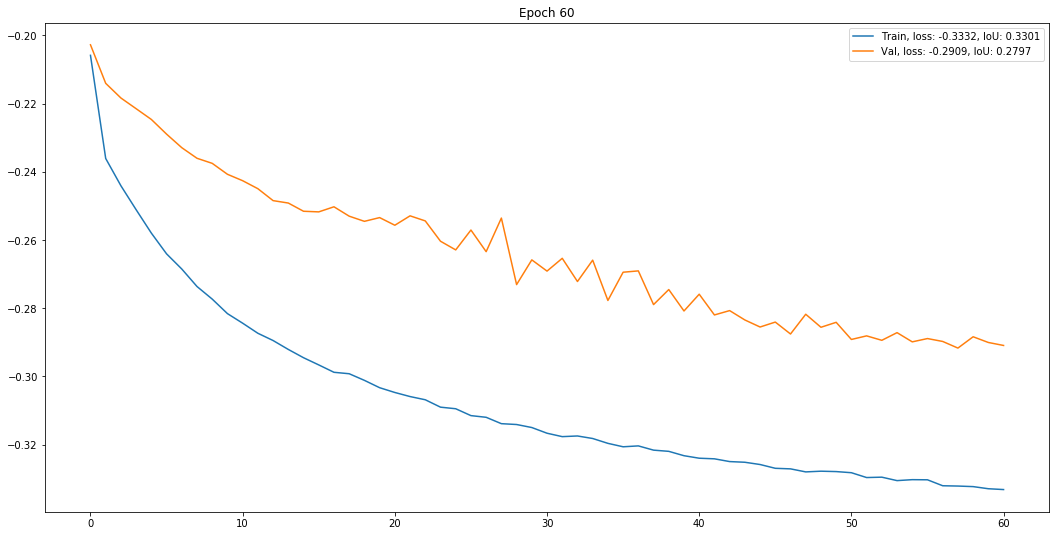

 Epoch: 61 of 70, Iter.: 44 of 44, Loss: -0.333431, Val. Loss: -0.292649
 Epoch: 61 of 70, Iter.: 44 of 44, IoU: 0.330236, Val. IoU: 0.279189


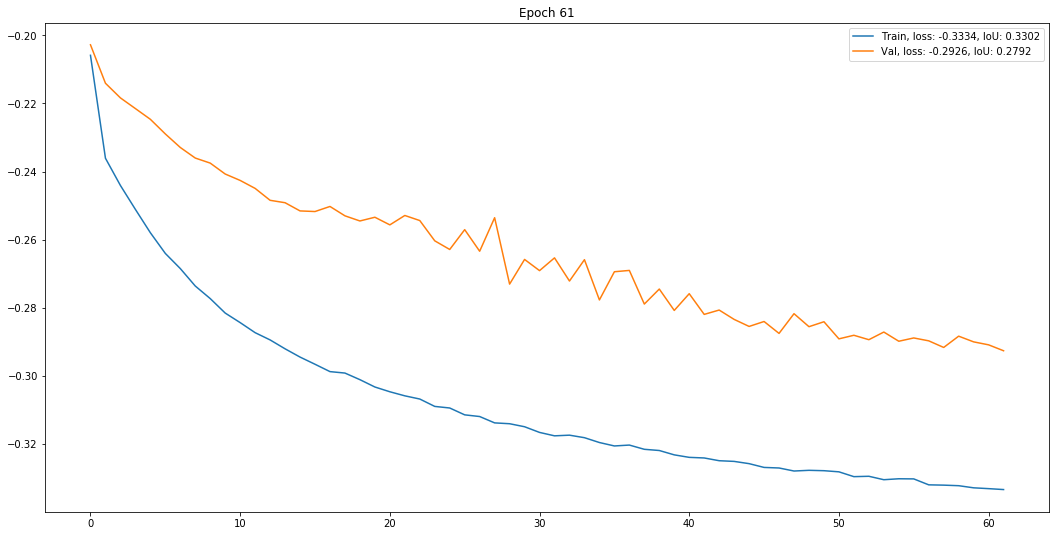

 Epoch: 62 of 70, Iter.: 44 of 44, Loss: -0.333995, Val. Loss: -0.291673
 Epoch: 62 of 70, Iter.: 44 of 44, IoU: 0.330962, Val. IoU: 0.276443


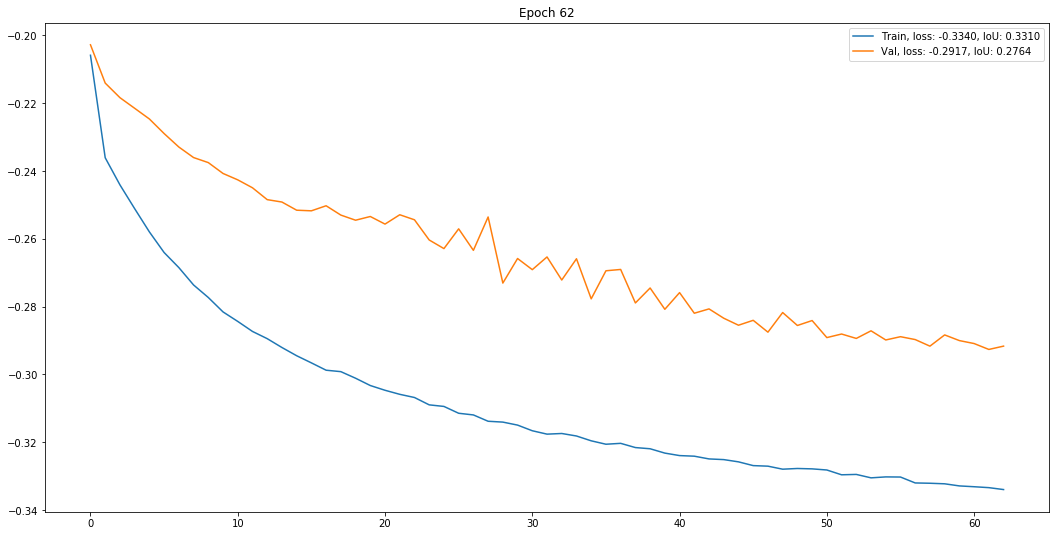

 Epoch: 63 of 70, Iter.: 44 of 44, Loss: -0.334015, Val. Loss: -0.292025
 Epoch: 63 of 70, Iter.: 44 of 44, IoU: 0.330966, Val. IoU: 0.279449


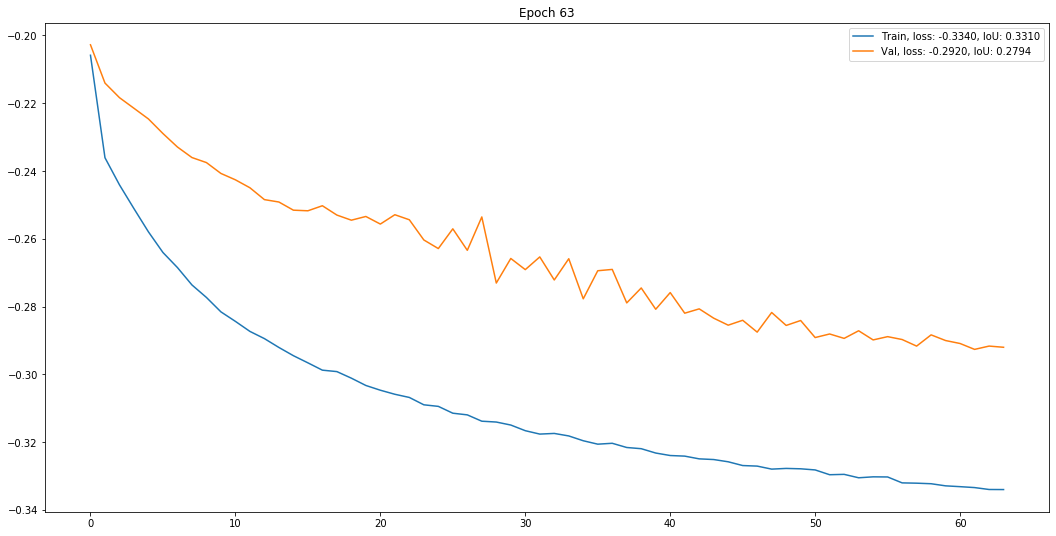

 Epoch: 64 of 70, Iter.: 44 of 44, Loss: -0.334240, Val. Loss: -0.292262
 Epoch: 64 of 70, Iter.: 44 of 44, IoU: 0.331070, Val. IoU: 0.280274


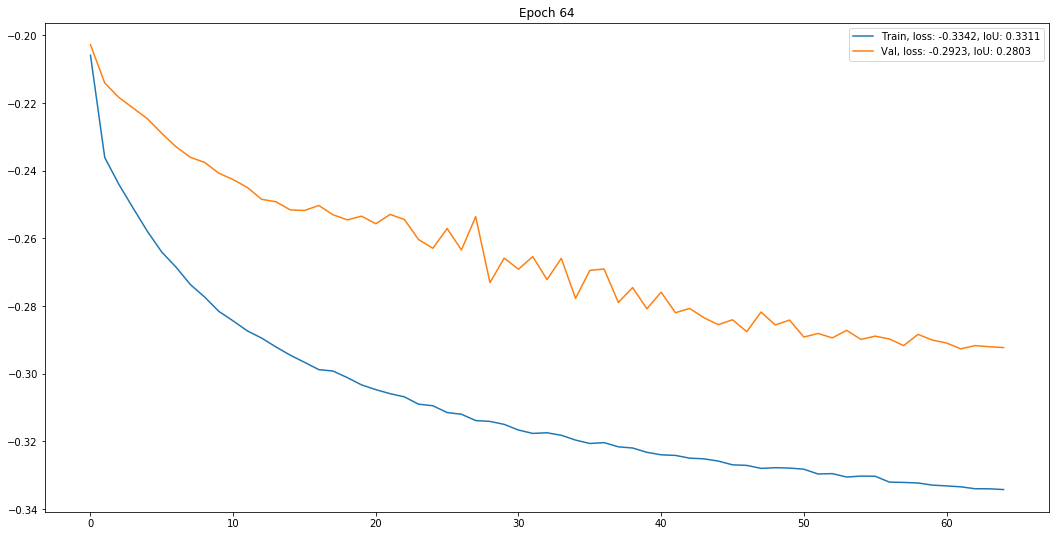

 Epoch: 65 of 70, Iter.: 44 of 44, Loss: -0.333605, Val. Loss: -0.293450
 Epoch: 65 of 70, Iter.: 44 of 44, IoU: 0.330200, Val. IoU: 0.279683


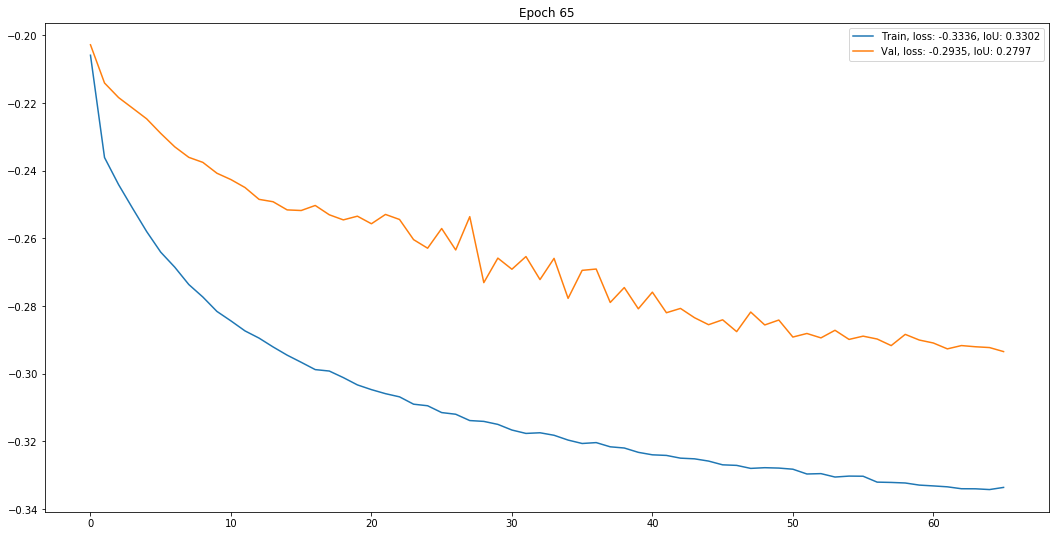

 Epoch: 66 of 70, Iter.: 44 of 44, Loss: -0.334204, Val. Loss: -0.292869
 Epoch: 66 of 70, Iter.: 44 of 44, IoU: 0.331111, Val. IoU: 0.280019


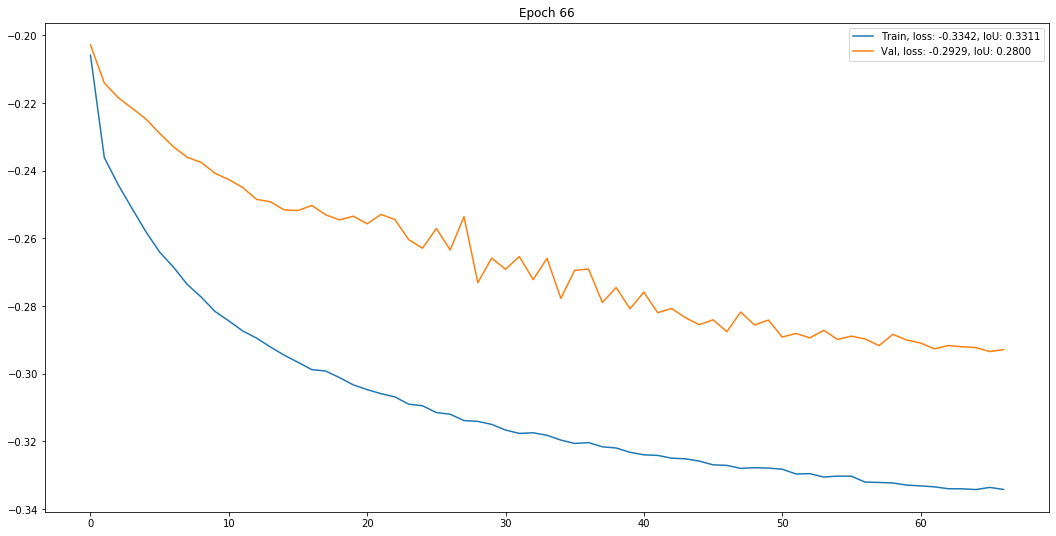

 Epoch: 67 of 70, Iter.: 44 of 44, Loss: -0.336124, Val. Loss: -0.293222
 Epoch: 67 of 70, Iter.: 44 of 44, IoU: 0.332548, Val. IoU: 0.279392


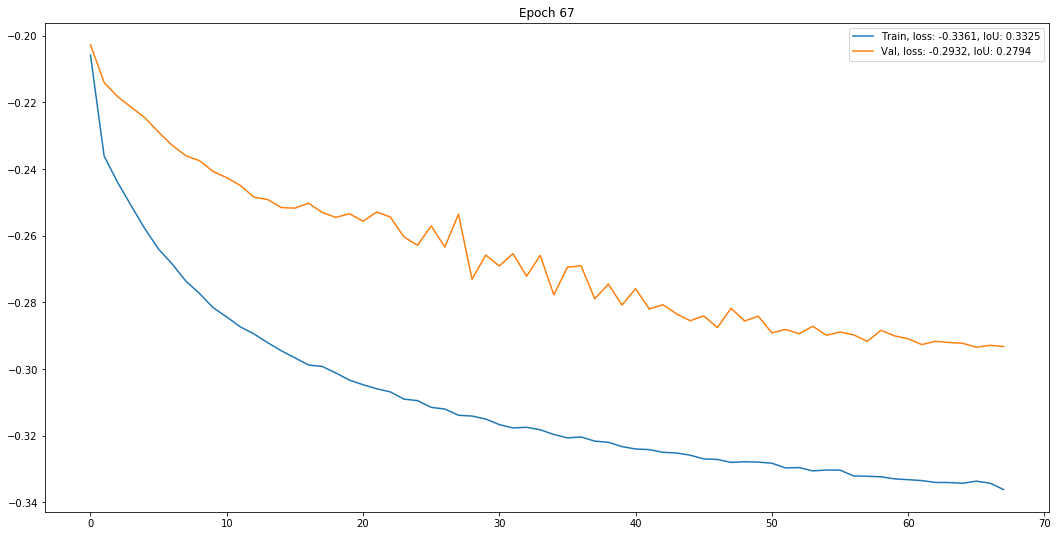

 Epoch: 68 of 70, Iter.: 44 of 44, Loss: -0.333957, Val. Loss: -0.295032
 Epoch: 68 of 70, Iter.: 44 of 44, IoU: 0.330587, Val. IoU: 0.278565


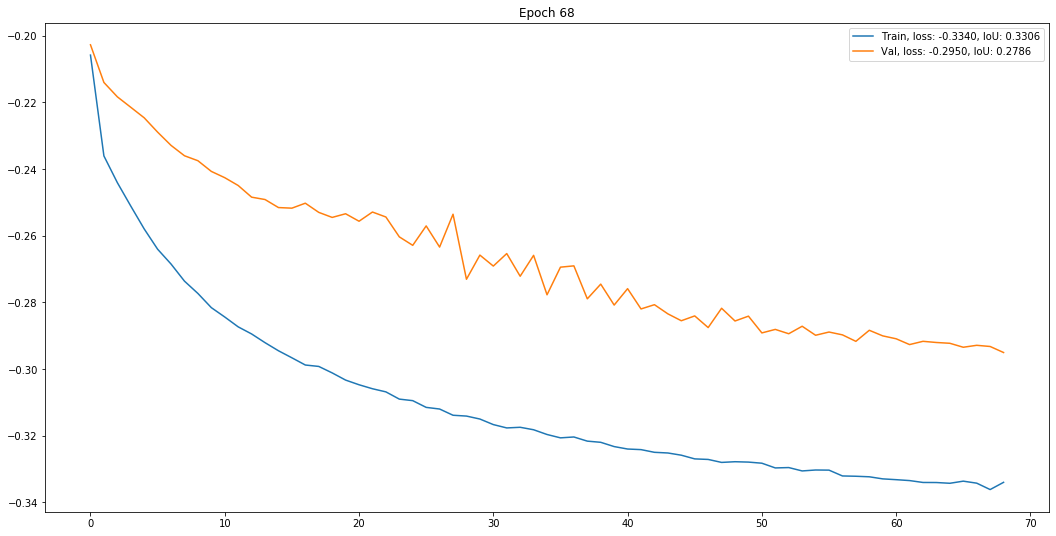

 Epoch: 69 of 70, Iter.: 44 of 44, Loss: -0.336283, Val. Loss: -0.293646
 Epoch: 69 of 70, Iter.: 44 of 44, IoU: 0.331507, Val. IoU: 0.279260


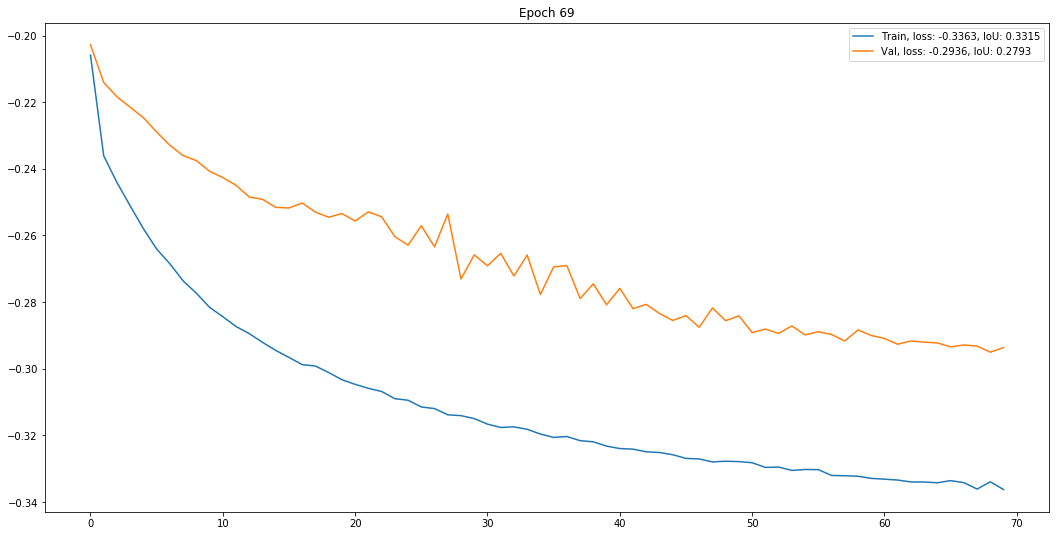

In [21]:
train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_val_loss))
    print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_iou, epoch_val_iou))
    
    
    # plot 
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    if best_epoch == epoch:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'iou': best_iou,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [22]:
best_epoch, best_iou

(64, tensor(0.2803, device='cuda:0'))

In [23]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()

## Evaluate validation performance (full sized images)

In [24]:
%ls ../checkpoints

ckpt_UNet_BCELoss_baseline.pth     ckpt_UNet_IoULoss_augmented.pth
ckpt_UNet_IoUBCELoss_baseline.pth  ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoULoss_attention.pth    README.md


In [25]:
# model_name = 'UNet_BCEWithLogitsLoss_attention'
model_name = 'UNet_IoULoss_attention'
# model_name = 'UNet_IoUBCELoss_attention'


# Begin training
model = UNet_attention(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

<All keys matched successfully>

In [26]:
print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
print(f'Validation IoU ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'].item())

Best epoch: 64
Validation IoU (256x256): 0.28027355670928955
